# Main notebook for collecting everything from "gennembrudsfiler" in a better (and useful) way...

In [2]:
# %matplotlib widget
# Load packages and settings
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 50)
import seaborn as sns



import sys
sys.path.append("./../scripts")
import PandemiXFunctions as pf

import geopandas as gpd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams["image.cmap"] = "tab10"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
fs_label = 16
parameters = {
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.markersize': 10,
                'lines.linewidth': 3
             }
plt.rcParams.update(parameters)
from matplotlib import cm # Colormaps
import matplotlib.colors as colors
# cmap = plt.cm.get_cmap('Dark2',len(ageGroups))

import locale
import matplotlib.dates as mdates
# locale.setlocale(locale.LC_TIME,"Danish")
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
# ax1.spines['top'].set_visible(False) 

import os
# import csv
import math

# from datetime import date
import datetime


saveFigures = True
# saveFigures = False
print('saveFigures is set to: '+str(saveFigures))

print('Done loading packages')

saveFigures is set to: True
Done loading packages


In [3]:
# Define paths
rootdir_data = os.getcwd() +"/../DanskeData/" 

path_data = rootdir_data + "ssi_data/"
path_dash = rootdir_data + "ssi_dashboard/"
path_vacc = rootdir_data + "ssi_vacc/"

path_figs = os.getcwd() +"/../Figures/" 

In [4]:
# Cases for comparison
latestsubdir = list(os.walk(path_dash))[0][1][-1]
latestdir = path_dash + latestsubdir

dfReinfFile = pd.read_csv(latestdir+'/Regionalt_DB/24_reinfektioner_daglig_region.csv',encoding='latin1',delimiter = ';')
dfReinfFile['Prøvedato'] = pd.to_datetime(dfReinfFile['Prøvedato'])
# groupdf = df.groupby(['Prøvedato').sum()
# df_reinf = dfReinfFile[dfReinfFile['Type af tilfælde (reinfektion eller bekræftet tilfælde)'] == '1.Reinfektion'].groupby('Prøvedato').sum()
# df_inf = dfReinfFile[dfReinfFile['Type af tilfælde (reinfektion eller bekræftet tilfælde)'] != '1.Reinfektion'].groupby('Prøvedato').sum()
df_reinf = dfReinfFile[dfReinfFile['Type af tilfælde (reinfektion eller første infektion)'] == '1.Reinfektion'].groupby('Prøvedato').sum()
df_inf = dfReinfFile[dfReinfFile['Type af tilfælde (reinfektion eller første infektion)'] != '1.Reinfektion'].groupby('Prøvedato').sum()

# Each tuesday, data for the last 16 weeks were made available 
To minimize reporting delay, the most recent 16 weeks use the most recent file. To get the rest of the data, last row is used from each file.

For sanity, start with just population counts in table1

In [5]:
# Start by getting the most recent data

for k in range(0,7):
    dayToCheck = np.datetime64('today')-np.timedelta64(k,'D')
    thisWeekDay = (dayToCheck).astype(datetime.datetime).isoweekday()    
    if (thisWeekDay == 2):
        mostRecentTuesday = dayToCheck
        tuePath = 'SSI_data_'+str(dayToCheck)
        if (os.path.exists(path_data + tuePath) == False):
            print('No data for most recent tuesday... If after 14:00, download new data')
            tuePath = 'SSI_data_'+str(dayToCheck-np.timedelta64(7,'D')) 
print(f'Path to latest Tuesday was {tuePath}')

dirPath = path_data + tuePath + '/'

dfRecent = pd.read_csv(dirPath+'gennembrudsinfektioner_table1.csv',delimiter=';')


Path to latest Tuesday was SSI_data_2022-04-19


In [6]:
# Go through each tuesday, as long back as possible, and grab the last row

# Start by taking all data from the most recent file
df_main = dfRecent.copy()

# allRows = [] 
colNamesToChange = {
'antal_personer_alle_Fuld vaccineeffekt': 'antal_personer_alle_Fuld effekt efter primært forløb',
'antal_personer_Fuld vaccineeffekt': 'antal_personer_Fuld effekt efter primært forløb',
'antal_cases_Fuld vaccineeffekt': 'antal_cases_Fuld effekt efter primært forløb',
'antal_repositive_Fuld vaccineeffekt': 'antal_repositive_Fuld effekt efter primært forløb',
'antal_indlagte_Fuld vaccineeffekt': 'antal_indlagte_Fuld effekt efter primært forløb',
'antal_tests_Fuld vaccineeffekt': 'antal_tests_Fuld effekt efter primært forløb',
'antal_tests_total_Fuld vaccineeffekt': 'antal_tests_total_Fuld effekt efter primært forløb',
}

maxWeeksBack = 50
for k in range(1,maxWeeksBack):
    curTue = mostRecentTuesday - np.timedelta64(7*k,'D')
    curTuePath = 'SSI_data_'+str(curTue)

    dirPath = path_data + curTuePath + '/'
    filePath = dirPath+'gennembrudsinfektioner_table1.csv'
    if os.path.exists(filePath):
        df1 = pd.read_csv(filePath,delimiter=';')
    else:
        continue

    # Check length of "ugenummer" columns
    if (len(df1.iloc[0,0]) == 11):
        # If length is 11, the year was included

        # Figure out order, to be able to get oldest
        weekDTs = [np.datetime64(datetime.datetime.strptime(d[-4:] + '-W'+d[4:6]+'-1', "%Y-W%W-%w")) for d in df1.Ugenummer]
        curOrder = np.argsort(weekDTs)
        df1 = df1.rename(columns=colNamesToChange) 

        oldestIndex = np.where(curOrder == 0)[0][0]
        # print(df1.iloc[oldestIndex,0])
        # display(df1.iloc[oldestIndex,1])

        # allRows.append(df1.iloc[oldestIndex,:])
        # df_main = df_main.append(df1.iloc[oldestIndex,:])
        df_main = pd.concat([df_main,df1.iloc[oldestIndex:oldestIndex+1,:]])
    else:
        # display(df1)

        # Rename weeknumber to have year
        df1.iloc[-1,0] = df1.iloc[-1,0] + '-2021'
        # And rename "Fuld Effekt" columns
        df1 = df1.rename(columns=colNamesToChange) 



        # print(df1.iloc[-1,0])
        # allRows.append(df1.iloc[-1,:])
        # df_main = df_main.append(df1.iloc[-1,:])
        df_main = pd.concat([df_main,df1.iloc[-1:,:]])


In [7]:
# Reset indices, correct the order and fill NaN
df_main = df_main.fillna(0)
df_main = df_main[::-1]
df_main = df_main.reset_index(drop=True)

In [8]:
df_main

,Ugenummer,antal_personer_alle_Ingen vaccination,antal_personer_alle_Første vaccination,antal_personer_alle_Anden vaccination,antal_personer_alle_Fuld effekt efter primært forløb,antal_personer_alle_Fuld effekt efter revaccination,antal_personer_Ingen vaccination,antal_personer_Første vaccination,antal_personer_Anden vaccination,antal_personer_Fuld effekt efter primært forløb,...,antal_repositive_Ingen vaccination,antal_repositive_Første vaccination,antal_repositive_Anden vaccination,antal_repositive_Fuld effekt efter primært forløb,antal_repositive_Fuld effekt efter revaccination,antal_indlagte_Ingen vaccination,antal_indlagte_Første vaccination,antal_indlagte_Anden vaccination,antal_indlagte_Fuld effekt efter primært forløb,antal_indlagte_Fuld effekt efter revaccination
0,Uge 21-2021,3992139,688900,1186483,1055605,0.0,3809066,664767,1152180,1025653,...,40,4,4,4,0.0,39,9,10,10,0.0
1,Uge 22-2021,3734883,880120,1255194,1175731,0.0,3557077,848300,1218103,1141842,...,31,4,6,6,0.0,21,6,9,9,0.0
2,Uge 23-2021,3476258,1023968,1372191,1257643,0.0,3303222,985104,1331065,1220463,...,30,3,6,5,0.0,17,5,4,4,0.0
3,Uge 24-2021,3143823,1225848,1504944,1346139,0.0,2978913,1175635,1459822,1305771,...,15,5,2,2,0.0,59,8,10,8,0.0
4,Uge 25-2021,2840153,1380484,1653882,1473979,0.0,2684180,1319386,1603826,1429640,...,10,1,1,1,0.0,28,9,7,5,0.0
5,Uge 26-2021,2618016,1403070,1853250,1525535,0.0,2468090,1337290,1795264,1479587,...,20,8,4,3,0.0,28,5,4,3,0.0
6,Uge 27-2021,2452684,1310565,2114638,1678255,0.0,2307824,1245075,2045506,1626964,...,49,10,6,6,0.0,41,11,8,6,0.0
7,Uge 28-2021,2177158,1348997,2353093,1885891,0.0,2044517,1278217,2273991,1826203,...,56,18,15,13,0.0,67,16,17,15,0.0
8,Uge 29-2021,1951031,1270038,2659201,2156178,0.0,1828566,1201455,2566094,2085108,...,45,8,4,3,0.0,66,12,18,14,0.0
9,Uge 30-2021,1776148,1128721,2976366,2406397,0.0,1662283,1066345,2867241,2324726,...,75,10,12,9,0.0,68,21,23,21,0.0


In [9]:
# allRows[-7]
df_main

allDTs = []
for k in range(len(df_main)):
    curWN = df_main.iloc[k,0]
    if len(curWN)==11: 
        curDT = np.datetime64(datetime.datetime.strptime(curWN[-4:] + '-W'+curWN[4:6]+'-1', "%Y-W%W-%w"))
    else:
        curDT = np.datetime64(datetime.datetime.strptime('2021-W'+curWN[4:6]+'-1', "%Y-W%W-%w"))
    allDTs.append(curDT)



In [10]:
sNone = 'Ingen vaccination'
sOnce = 'Første vaccination'
sBoth = 'Anden vaccination'
sFull = 'Fuld effekt efter primært forløb'
sReva = 'Fuld effekt efter revaccination'

allS = [sNone,sOnce,sBoth,sFull,sReva] 

In [11]:
# curData = 'antal_personer_alle_'
# curData = 'antal_personer_'

# unva = df_main[curData+sNone]
# once = df_main[curData+sOnce]
# both = df_main[curData+sBoth]
# full = df_main[curData+sFull]
# reva = df_main[curData+sReva]

# # once = df_main.iloc[:,2]
# # both = df_main.iloc[:,3]
# # full_pri = df_main.iloc[:,4].fillna(0)
# # full_old = df_main.iloc[:,-4].fillna(0)
# # full = full_pri + full_old
# # reva = df_main.iloc[:,5].fillna(0)

# fig,ax1 = plt.subplots()

# ax1.plot(allDTs,unva)
# ax1.plot(allDTs,once)
# ax1.plot(allDTs,both)
# ax1.plot(allDTs,full)
# ax1.plot(allDTs,reva)

In [12]:

# unva = df_main.iloc[:,1]
# once = df_main.iloc[:,2]
# both = df_main.iloc[:,3]
# full_pri = df_main.iloc[:,4].fillna(0)
# full_old = df_main.iloc[:,-4].fillna(0)
# full = full_pri + full_old
# reva = df_main.iloc[:,5].fillna(0)


curData = 'antal_personer_alle_'
# curData = 'antal_personer_'

unva = df_main[curData+sNone]
once = df_main[curData+sOnce]
both = df_main[curData+sBoth]
full = df_main[curData+sFull]
reva = df_main[curData+sReva]


popSize = unva+once+both

# fig,ax1 = plt.subplots()

# ax1.stackplot(allDTs,
#                 reva,
#                 full,
#                 both-full-reva,
#                 once,
#                 unva,
#                 colors=['xkcd:dark green','xkcd:green','xkcd:cyan','xkcd:blue','m'],
#                 labels=['Full effect after booster','Full effect after two doses','Two doses','One dose','Unvaccinated']
#         )
        

# ax1.legend(loc='upper left')

# ax1.set_xlim([np.min(allDTs),np.max(allDTs)])

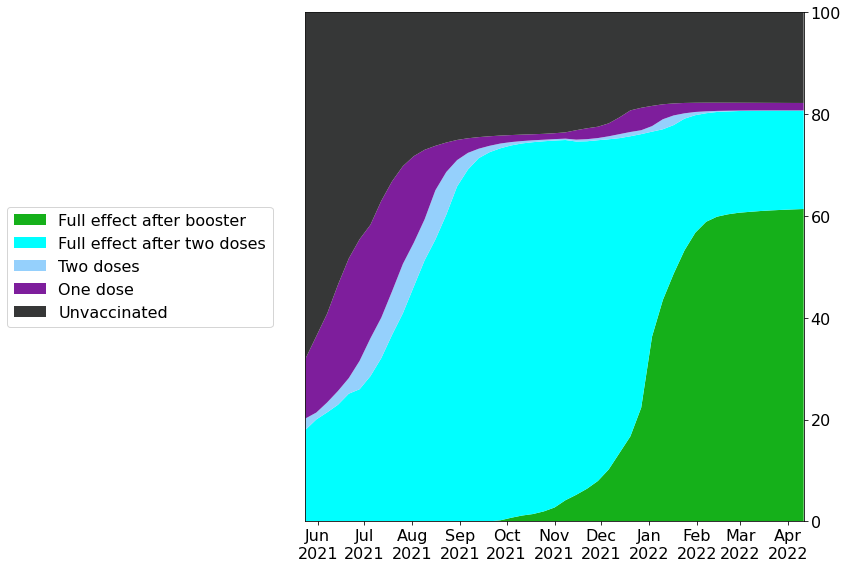

In [13]:

fig,ax1 = plt.subplots()
ax1.stackplot(allDTs,
                100*(reva)/popSize,
                100*(full)/popSize,
                100*(both-full-reva)/popSize,
                100*(once)/popSize,
                100*(unva)/popSize,
                colors=['xkcd:green','xkcd:cyan','xkcd:light blue','xkcd:purple','xkcd:dark grey'],
                labels=['Full effect after booster','Full effect after two doses','Two doses','One dose','Unvaccinated']
        )
        
# ax1.set_ylim([0,100])
# # ax1.legend(loc='upper left')
# ax1.legend(bbox_to_anchor=(-0.05,0.5),loc='center left')

# ax1.set_xlim([np.min(allDTs),np.max(allDTs)])
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))



# fig.tight_layout()
ax1.set_ylim([0,100])
# ax1.legend(loc='upper left')
# ax1.legend(bbox_to_anchor=(1.05,0.5),loc='center left')
ax1.legend(bbox_to_anchor=(-0.05,0.5),loc='center right')

ax1.set_xlim([np.min(allDTs),np.max(allDTs)])

ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()


ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

fig.tight_layout()

fig.savefig(path_figs+'Immunity/TotalPopulationImmunity_VaccineOnly')


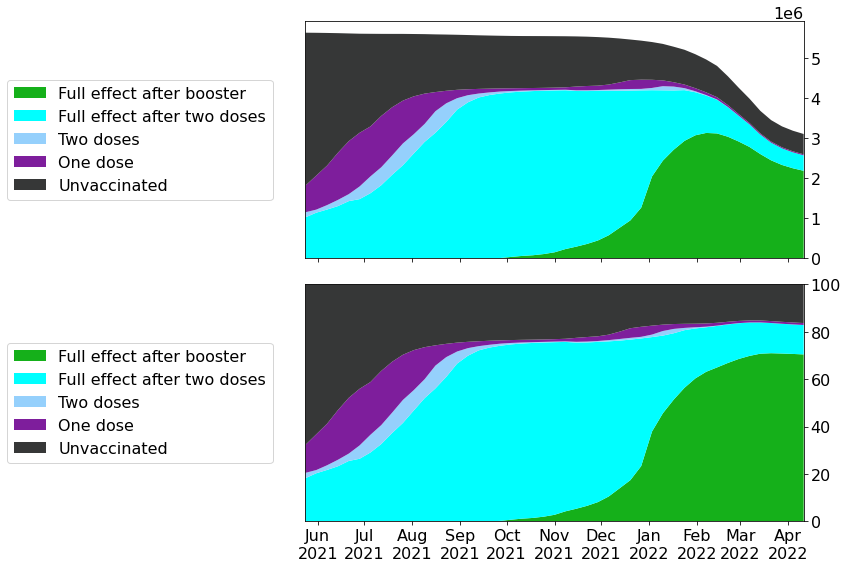

In [14]:

# unva = df_main.iloc[:,6]
# once = df_main.iloc[:,7]
# both = df_main.iloc[:,8]
# full_pri = df_main.iloc[:,4].fillna(0)
# full_old = df_main.iloc[:,-4].fillna(0)
# full = full_pri + full_old
# reva = df_main.iloc[:,9].fillna(0)



# curData = 'antal_personer_alle_'
curData = 'antal_personer_'

unva = df_main[curData+sNone]
once = df_main[curData+sOnce]
both = df_main[curData+sBoth]
full = df_main[curData+sFull]
reva = df_main[curData+sReva]

popSize = unva+once+both

fig,(ax1,ax2) = plt.subplots(2,1,sharex=True)


ax1.stackplot(allDTs,
                reva,
                full,
                both-full-reva,
                once,
                unva,
                colors=['xkcd:green','xkcd:cyan','xkcd:light blue','xkcd:purple','xkcd:dark grey'],
                labels=['Full effect after booster','Full effect after two doses','Two doses','One dose','Unvaccinated']
        )
        
        
ax2.stackplot(allDTs,
                100*reva/popSize,
                100*full/popSize,
                100*(both-full-reva)/popSize,
                100*once/popSize,
                100*unva/popSize,
                colors=['xkcd:green','xkcd:cyan','xkcd:light blue','xkcd:purple','xkcd:dark grey'],
                labels=['Full effect after booster','Full effect after two doses','Two doses','One dose','Unvaccinated']
        )
        
ax1.legend(bbox_to_anchor=(-0.05,0.5),loc='center right')
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax2.set_ylim([0,100])
ax2.legend(bbox_to_anchor=(-0.05,0.5),loc='center right')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()


ax1.set_xlim([np.min(allDTs),np.max(allDTs)])
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

fig.tight_layout()

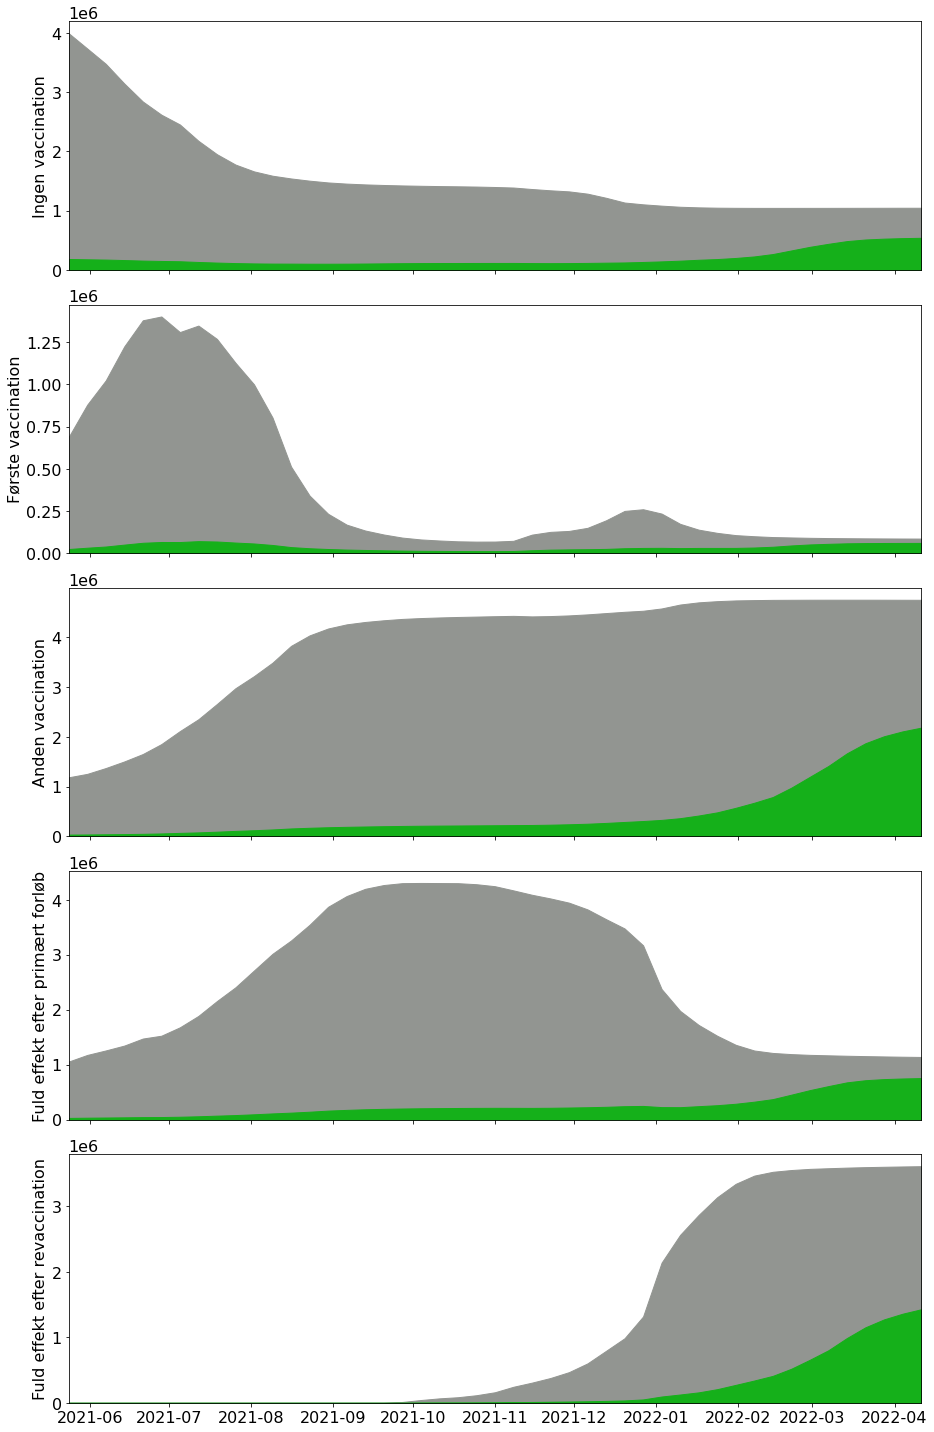

In [15]:
# Make comparative plots of population sizes
fig,allAx = plt.subplots(5,1,figsize=(13,20),sharex=True)

# ax = allAx[0]

# curStatus = sNone 

for i,curStatus in enumerate(allS):
    ax = allAx[i]
    curAll = df_main['antal_personer_alle_'+curStatus]
    curPer = df_main['antal_personer_'+curStatus]
    curDif = curAll-curPer 
    ax.fill_between(allDTs,curAll,color='xkcd:grey')
    ax.fill_between(allDTs,curDif,color='xkcd:green')
    ax.set_ylabel(curStatus)
    ax.set_ylim(bottom=0)

ax.set_xlim(allDTs[0],allDTs[-1])
fig.tight_layout()

In [16]:
# curPer

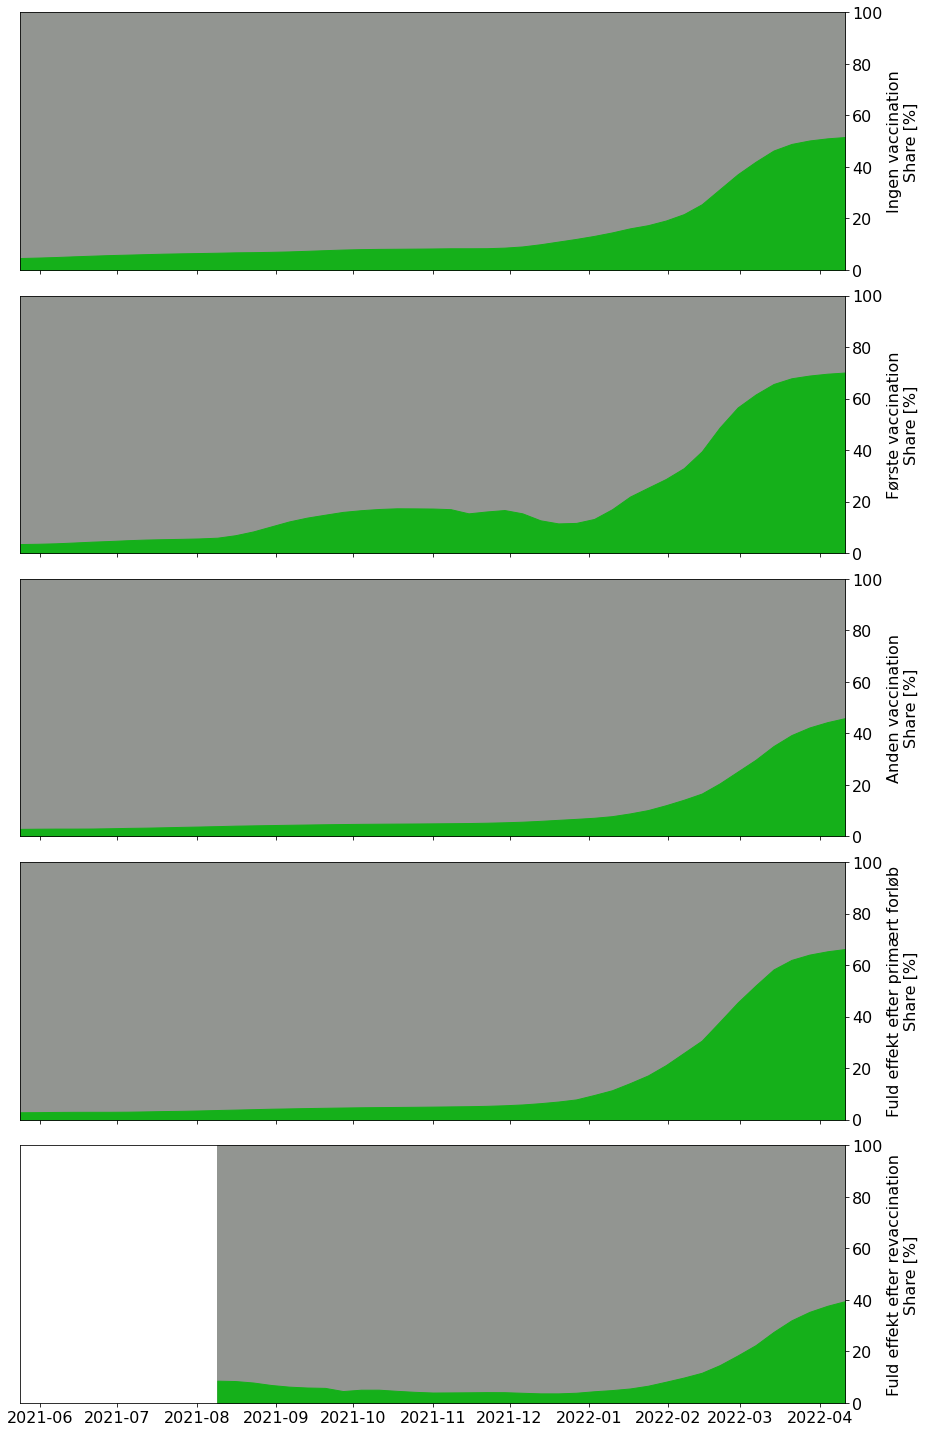

In [17]:
# As above, but as a fraction
fig,allAx = plt.subplots(5,1,figsize=(13,20),sharex=True)


for i,curStatus in enumerate(allS):
    ax = allAx[i]
    curAll = df_main['antal_personer_alle_'+curStatus]
    curPer = df_main['antal_personer_'+curStatus]
    curDif = curAll-curPer 
    ax.fill_between(allDTs,100*curAll/curAll,color='xkcd:grey')
    ax.fill_between(allDTs,100*curDif/curAll,color='xkcd:green')
    ax.set_ylabel(curStatus+'\nShare [%]')
    ax.set_ylim(bottom=0,top=100)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")

ax.set_xlim(allDTs[0],allDTs[-1])
fig.tight_layout()

# Figures as if data was up-to-date

In [18]:
curData = 'antal_personer_alle_'


unva = df_main[curData+sNone]
once = df_main[curData+sOnce]
both = df_main[curData+sBoth]
full = df_main[curData+sFull]
reva = df_main[curData+sReva]

popSize = unva+once+both

curData = 'antal_personer_'

unva_neg = df_main[curData+sNone]
once_neg = df_main[curData+sOnce]
both_neg = df_main[curData+sBoth]
full_neg = df_main[curData+sFull]
reva_neg = df_main[curData+sReva]


unva_pos = unva - unva_neg
once_pos = once - once_neg
both_pos = both - both_neg
full_pos = full - full_neg
reva_pos = reva - reva_neg

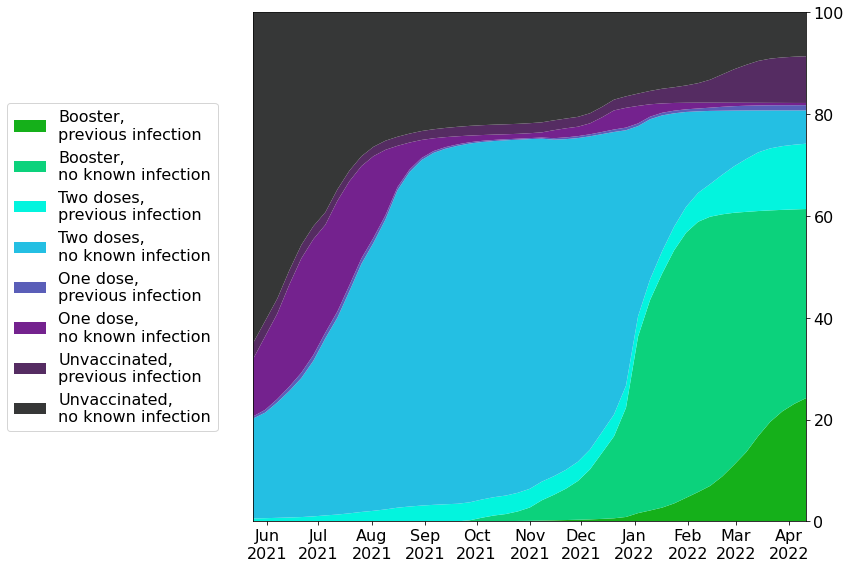

In [19]:



cmap = pf.getColormapFromList(['xkcd:green','xkcd:cyan','xkcd:purple','xkcd:dark grey'],8)
allLabels= ['Booster,\nprevious infection','Booster,\nno known infection','Two doses,\nprevious infection','Two doses,\nno known infection','One dose,\nprevious infection','One dose,\nno known infection','Unvaccinated,\nprevious infection','Unvaccinated,\nno known infection']
fig,ax1 = plt.subplots()
ax1.stackplot(allDTs,
                100*(reva_pos)/popSize,
                100*(reva_neg)/popSize,
                # 100*(full_pos)/popSize,
                # 100*(full_neg)/popSize,
                # 100*(both_pos-full_pos-reva_pos)/popSize,
                # 100*(both_neg-full_neg-reva_neg)/popSize,
                100*(both_pos-reva_pos)/popSize,
                100*(both_neg-reva_neg)/popSize,
                100*(once_pos)/popSize,
                100*(once_neg)/popSize,
                100*(unva_pos)/popSize,
                100*(unva_neg)/popSize,
                # colors=['xkcd:dark green','xkcd:green','xkcd:cyan','xkcd:blue','m'],
                # labels=['Full effect after booster','Full effect after two doses','Two doses','One dose','Unvaccinated']
                colors = [cmap(k) for k in range(0,8)],
                labels= allLabels 
        )
        
ax1.set_ylim([0,100])
# ax1.legend(loc='upper left')
# ax1.legend(bbox_to_anchor=(1.05,0.5),loc='center left')
ax1.legend(bbox_to_anchor=(-0.05,0.5),loc='center right')

ax1.set_xlim([np.min(allDTs),np.max(allDTs)])

ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()


ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

fig.tight_layout()

fig.savefig(path_figs+'Immunity/TotalPopulationImmunity')

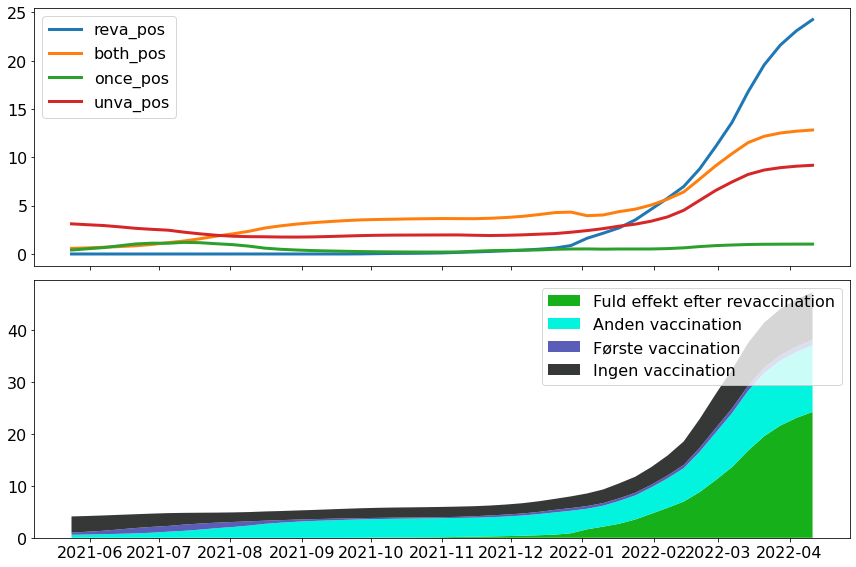

In [20]:
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True)
ax1.plot(allDTs,100*(reva_pos)/popSize,label='reva_pos')
ax1.plot(allDTs,100*(both_pos-reva_pos)/popSize,label='both_pos')
ax1.plot(allDTs,100*(once_pos)/popSize,label='once_pos')
ax1.plot(allDTs,100*(unva_pos)/popSize,label='unva_pos')
ax1.legend()

ax2.stackplot(allDTs,
            100*reva_pos/popSize,
            100*(both_pos-reva_pos)/popSize,
            100*once_pos/popSize,
            100*unva_pos/popSize,    
            colors=[cmap(0),cmap(2),cmap(4),cmap(8)],
            labels=[sReva,sBoth,sOnce,sNone]        
    )
ax2.legend()

fig.tight_layout()

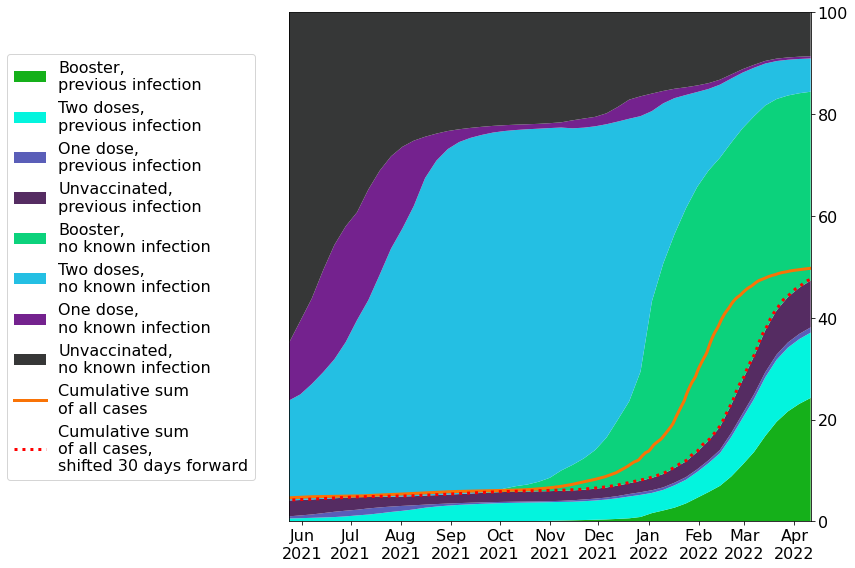

In [21]:
fig,ax1 = plt.subplots()
ax1.stackplot(allDTs,
                100*(reva_pos)/popSize,
                100*(both_pos-reva_pos)/popSize,
                100*(once_pos)/popSize,
                100*(unva_pos)/popSize,
                100*(reva_neg)/popSize,
                100*(both_neg-reva_neg)/popSize,
                100*(once_neg)/popSize,
                100*(unva_neg)/popSize,
                colors = [cmap(0),cmap(2),cmap(4),cmap(6),cmap(1),cmap(3),cmap(5),cmap(7)],
                labels= [allLabels[0],allLabels[2],allLabels[4],allLabels[6],allLabels[1],allLabels[3],allLabels[5],allLabels[7]],
                # labels=['Booster,\nprevious infection','Booster,\nno known infection','Two doses,\nprevious infection','Two doses,\nno known infection','One dose,\nprevious infection','One dose,\nno known infection','Unvaccinated,\nprevious infection','Unvaccinated,\nno known infection']
        )
        
ax1.set_ylim([0,100])
# ax1.legend(loc='upper left')
# ax1.legend(bbox_to_anchor=(1.05,0.5),loc='center left')
ax1.legend(bbox_to_anchor=(-0.05,0.5),loc='center right')

ax1.set_xlim([np.min(allDTs),np.max(allDTs)])

ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()


ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))



fig.tight_layout()

fig.savefig(path_figs+'Immunity/TotalPopulationImmunity_PosNeg')


dkPop = popSize.values[-1]
ax1.plot(df_inf.index,100*np.cumsum(df_inf.infected)/dkPop,'xkcd:orange',label='Cumulative sum\nof all cases')
ax1.plot(df_inf.index+np.timedelta64(30,'D'),100*np.cumsum(df_inf.infected)/dkPop,'r:',label='Cumulative sum\nof all cases,\nshifted 30 days forward')
ax1.legend(bbox_to_anchor=(-0.05,0.5),loc='center right')

fig.tight_layout()

fig.savefig(path_figs+'Immunity/TotalPopulationImmunity_PosNeg_Compare')


# Try to compare cases with national numbers

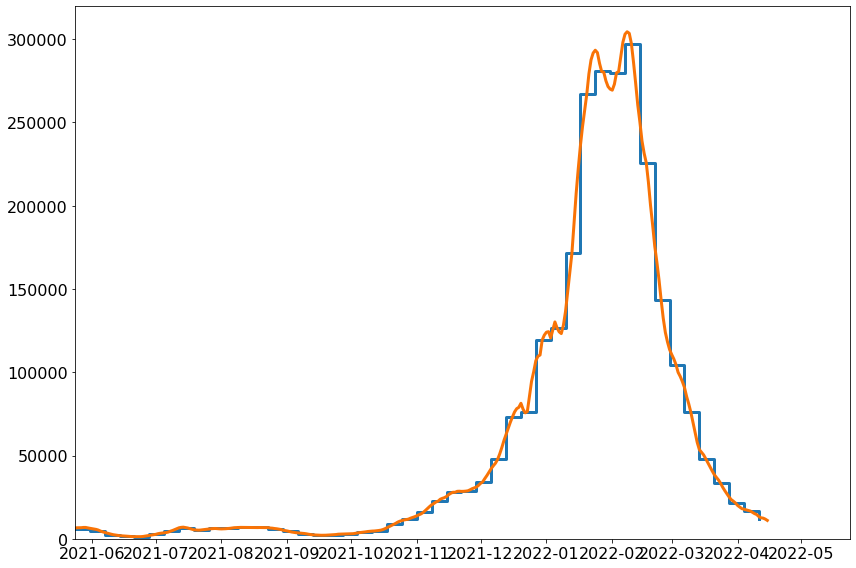

In [22]:
firstCaseIndex = np.where(df_main.columns == 'antal_cases_Ingen vaccination')[0][0]

totCase = df_main.iloc[:,firstCaseIndex:firstCaseIndex+3].sum(axis=1)
# totCase

fig,ax1 = plt.subplots()
ax1.step(allDTs,totCase,where='post')
# ax1.plot(allDTs,totCase,'*:')
# ax1.plot(df_inf.index,df_inf.infected,'xkcd:orange',label='Fra regional_DB filer')
ax1.plot(pf.rnTime(df_inf.index),pf.rnMean(df_inf.infected)*7,'xkcd:orange',label='Fra regional_DB filer')

ax1.set_xlim(left=allDTs[0])
ax1.set_ylim(bottom=0)

fig.tight_layout()

In [23]:
# prevPos = (totAlle - totPers).values[:-4]


# prevCase = np.cumsum(totCase) + (totAlle[0]-totPers[0])
# curPos = prevCase[4:] - prevCase[:-4]

# curPos[-4:]

# print(np.concatenate([(curAlle-curPers)[4:],prevNone[-4:]]))
# print(np.concatenate([(curAlle-curPers)[5:],prevNone[-5:]]))


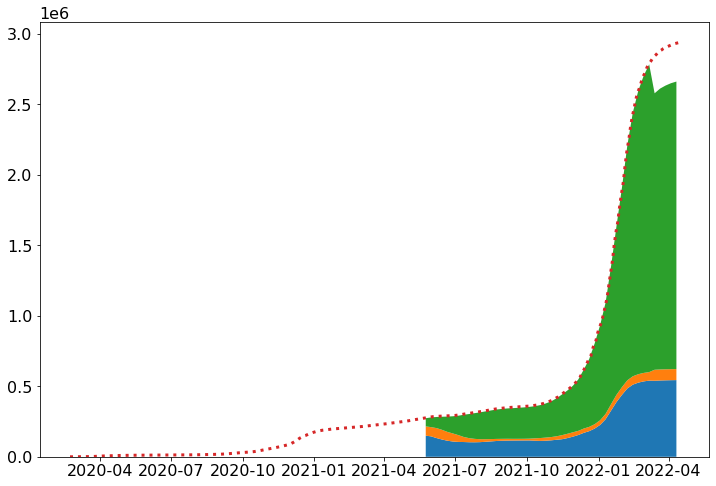

In [24]:
# curdf = df_main.iloc[-20:,:]
# curDates = allDTs[-20:]
curdf = df_main.copy()
curDates = allDTs.copy()

curS = sNone
curAlle = curdf.loc[:,'antal_personer_alle_'+curS].values
curPers = curdf.loc[:,'antal_personer_'+curS].values
curDif = curAlle - curPers
# prevNone = np.cumsum(curdf.loc[:,'antal_cases_'+curS]) + curDif[0]
prevNone = np.cumsum(curdf.loc[:,'antal_cases_'+curS]) 
toUseNone = np.concatenate([(curAlle-curPers)[5:],prevNone[-5:]])


curS = sOnce
curAlle = curdf.loc[:,'antal_personer_alle_'+curS].values
curPers = curdf.loc[:,'antal_personer_'+curS].values
curDif = curAlle - curPers
prevOnce = np.cumsum(curdf.loc[:,'antal_cases_'+curS]) 
toUseOnce = np.concatenate([(curAlle-curPers)[5:],prevOnce[-5:]])
# toUseOnce = np.concatenate([(curAlle-curPers)[6:],prevOnce[-6:]])

curS = sBoth
curAlle = curdf.loc[:,'antal_personer_alle_'+curS].values
curPers = curdf.loc[:,'antal_personer_'+curS].values
curDif = curAlle - curPers
prevBoth = np.cumsum(curdf.loc[:,'antal_cases_'+curS]) 
toUseBoth = np.concatenate([(curAlle-curPers)[5:],prevBoth[-5:]])
# toUseBoth = np.concatenate([(curAlle-curPers)[4:],prevBoth[-4:]])

curS = sFull
curAlle = curdf.loc[:,'antal_personer_alle_'+curS].values
curPers = curdf.loc[:,'antal_personer_'+curS].values
curDif = curAlle - curPers
prevFull = np.cumsum(curdf.loc[:,'antal_cases_'+curS]) 
toUseFull = np.concatenate([(curAlle-curPers)[5:],prevFull[-5:]])

curS = sReva
curAlle = curdf.loc[:,'antal_personer_alle_'+curS].values
curPers = curdf.loc[:,'antal_personer_'+curS].values
curDif = curAlle - curPers
prevReva = np.cumsum(curdf.loc[:,'antal_cases_'+curS]) 
toUseReva = np.concatenate([(curAlle-curPers)[5:],prevReva[-5:]])

fig,ax1 = plt.subplots()

# ax1.plot(curDates,prevNone)
# ax1.plot(curDates,toUseNone,':')

# ax1.plot(curDates,prevOnce)
# ax1.plot(curDates,toUseOnce,':')


# ax1.plot(curDates,prevBoth)
# ax1.plot(curDates,toUseBoth,':')

# ax1.plot(curDates[:-5],curDif[5:],'--')
# ax1.plot(curDates,prevOnce)
# ax1.plot(curDates,prevBoth)


ax1.stackplot(curDates,
            toUseNone,
            toUseOnce,
            toUseBoth
        )
        
# ax1.stackplot(curDates,
#             prevNone,
#             prevOnce,
#             prevBoth
#         )
        
# ax1.plot(curDates,curDif)


ax1.plot(df_inf.index-np.timedelta64(4,'D'),np.cumsum(df_inf.infected),':',label='Fra regional_DB filer')

In [25]:
plt.close('all')

# Look at the other files

In [26]:
for k in range(0,7):
    dayToCheck = np.datetime64('today')-np.timedelta64(k,'D')
    thisWeekDay = (dayToCheck).astype(datetime.datetime).isoweekday()    
    if (thisWeekDay == 2):
        mostRecentTuesday = dayToCheck
        tuePath = 'SSI_data_'+str(dayToCheck)
        if (os.path.exists(path_data + tuePath) == False):
            print('No data for most recent tuesday... If after 14:00, download new data')
            tuePath = 'SSI_data_'+str(dayToCheck-np.timedelta64(7,'D')) 
            mostRecentTuesday = dayToCheck-np.timedelta64(7,'D')

print(f'Path to latest Tuesday was {tuePath}')

dirPath = path_data + tuePath + '/'

df2_C = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_cases.csv',delimiter=';')
df3_C = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_cases.csv',delimiter=';')
df3_A = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_alle.csv',delimiter=';')

df2_T = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_tests.csv',delimiter=';')
df3_T = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_tests.csv',delimiter=';')

df2_H = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_indlagte.csv',delimiter=';')
df3_H = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_indlagte.csv',delimiter=';')
# df3_C.iloc[:,1:] = pd.to_numeric(df3_C.iloc[:,1:].str.replace(',','.'))
for col in df3_C.columns[1:]:
    df3_C[col] = pd.to_numeric(df3_C[col].str.replace(',','.'))
    df3_A[col] = pd.to_numeric(df3_A[col].str.replace(',','.'))
    df3_T[col] = pd.to_numeric(df3_T[col].str.replace(',','.'))
    df3_H[col] = pd.to_numeric(df3_H[col].str.replace(',','.'))

Path to latest Tuesday was SSI_data_2022-04-19


In [27]:

# df_Test_Count = df_Test_Count.join(toAppend)
# df_Test_Count.join(toAppend)
# df_Test_Count.iloc[:,-10:] 
# df_Test_Count.shape
# df3_T.shape

In [28]:
# Go through each tuesday, as long back as possible, and grab the last columns

df_Hosp_Inci  = df3_H.copy()
df_Hosp_Count = df2_H.copy()

df_Test_Inci  = df3_T.copy()
df_Test_Count = df2_T.copy()

df_Case_Inci  = df3_C.copy()
df_Case_InciAlle  = df3_C.copy()
df_Case_Count = df2_C.copy()
# df2_C = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_cases.csv',delimiter=';')
# df3_C = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_cases.csv',delimiter=';')
# df3_A = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_alle.csv',delimiter=';')

maxWeeksBack = 50
for k in range(1,maxWeeksBack):
    curTue = mostRecentTuesday - np.timedelta64(7*k,'D')
    curTuePath = 'SSI_data_'+str(curTue)

    dirPath = path_data + curTuePath + '/'

    
    filePath = dirPath+'gennembrudsinfektioner_table2_antal_indlagte.csv'
    if os.path.exists(filePath):
        df_H = pd.read_csv(filePath,delimiter=';')
    else:
        continue
    
    filePath = dirPath+'gennembrudsinfektioner_table2_incidence_indlagte.csv'
    if os.path.exists(filePath):
        df_H_I = pd.read_csv(filePath,delimiter=';')
    else:
        continue
    
    filePath = dirPath+'gennembrudsinfektioner_table2_antal_tests.csv'
    if os.path.exists(filePath):
        df_T = pd.read_csv(filePath,delimiter=';')
    else:
        continue
    
    filePath = dirPath+'gennembrudsinfektioner_table2_incidence_tests.csv'
    if os.path.exists(filePath):
        df_T_I = pd.read_csv(filePath,delimiter=';')
    else:
        continue
    
    filePath = dirPath+'gennembrudsinfektioner_table2_antal_cases.csv'
    if os.path.exists(filePath):
        df_C = pd.read_csv(filePath,delimiter=';')
    else:
        continue
    
    filePath = dirPath+'gennembrudsinfektioner_table2_incidence_cases.csv'
    if os.path.exists(filePath):
        df_C_I = pd.read_csv(filePath,delimiter=';')
    else:
        continue
    
    filePath = dirPath+'gennembrudsinfektioner_table2_incidence_alle.csv'
    if os.path.exists(filePath):
        df_C_I_A = pd.read_csv(filePath,delimiter=';')
    else:
        continue
    
    for col in df_T_I.columns[1:]:
        df_T_I[col] = pd.to_numeric(df_T_I[col].str.replace(',','.'))
        df_H_I[col] = pd.to_numeric(df_H_I[col].fillna(0).astype(str).str.replace(',','.'))
        df_C_I[col] = pd.to_numeric(df_C_I[col].fillna(0).astype(str).str.replace(',','.'))
        df_C_I_A[col] = pd.to_numeric(df_C_I_A[col].fillna(0).astype(str).str.replace(',','.'))

    # For now, only go back until registration style changed 
    if (df_T.shape == df3_T.shape):
        # df_Test_Inci
        allCols= [x[7:11]+x[4:6] for x in df_T.columns]
        oldestIndex = np.argsort(allCols)[0]
        # print(np.argsort(allCols)[0])
        # print(df_T.columns[oldestIndex-4])
        toAppend_H = df_H.iloc[:,oldestIndex-4:oldestIndex+1]
        toAppend_H_I = df_H_I.iloc[:,oldestIndex-4:oldestIndex+1]

        df_Hosp_Count = df_Hosp_Count.join(toAppend_H)
        df_Hosp_Inci = df_Hosp_Inci.join(toAppend_H_I)
        
        toAppend = df_T.iloc[:,oldestIndex-4:oldestIndex+1]
        toAppend_I = df_T_I.iloc[:,oldestIndex-4:oldestIndex+1]

        df_Test_Count = df_Test_Count.join(toAppend)
        df_Test_Inci = df_Test_Inci.join(toAppend_I)
        
        toAppend_C     = df_C.iloc[:,oldestIndex-4:oldestIndex+1]
        toAppend_C_I   = df_C_I.iloc[:,oldestIndex-4:oldestIndex+1]
        toAppend_C_I_A = df_C_I_A.iloc[:,oldestIndex-4:oldestIndex+1]

        df_Case_Count = df_Case_Count.join(toAppend_C)
        df_Case_Inci = df_Case_Inci.join(toAppend_C_I)
        df_Case_InciAlle = df_Case_InciAlle.join(toAppend_C_I_A)

        # print(np.sort(allCols)[0])
# df_T
# df_Test_Inci

In [29]:
# df_Hosp_Count
# df_H_I
# col
# df_Hosp_Inci.loc[:,1:].str.replace(',','.')
# toAppend_H_I
df_Hosp_Inci

,Aldersgruppe,Uge 15-2022_Ingen vaccination,Uge 15-2022_Første vaccination,Uge 15-2022_Anden vaccination,Uge 15-2022_Fuld effekt efter primært forløb,Uge 15-2022_Fuld effekt efter revaccination,Uge 14-2022_Ingen vaccination,Uge 14-2022_Første vaccination,Uge 14-2022_Anden vaccination,Uge 14-2022_Fuld effekt efter primært forløb,...,Uge 33-2021_Ingen vaccination,Uge 33-2021_Første vaccination,Uge 33-2021_Anden vaccination,Uge 33-2021_Fuld effekt efter primært forløb,Uge 33-2021_Fuld effekt efter revaccination,Uge 32-2021_Ingen vaccination,Uge 32-2021_Første vaccination,Uge 32-2021_Anden vaccination,Uge 32-2021_Fuld effekt efter primært forløb,Uge 32-2021_Fuld effekt efter revaccination
0,0-5,7.5,0.0,0.0,0.0,0.0,10.5,0.0,0.0,0.0,...,3.3,0.0,0.0,0.0,0,3.0,0.0,0.0,0.0,0
1,6-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.8,1.8,...,0.6,0.0,0.0,0.0,0,0.3,0.0,0.0,0.0,0
2,12-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,1.5,...,1.8,0.0,0.0,0.0,0,3.2,0.8,0.0,0.0,0
3,16-19,0.0,0.0,1.3,2.8,0.0,20.3,0.0,3.8,2.7,...,14.6,0.0,0.5,0.0,0,6.9,3.4,0.6,0.8,0
4,20-29,9.5,0.0,8.7,18.9,5.2,3.1,0.0,9.8,13.1,...,18.4,0.0,0.0,0.0,0,12.5,3.5,0.3,0.6,0
5,30-39,11.6,23.5,7.9,12.2,6.3,19.0,23.0,10.8,11.7,...,18.7,3.0,0.6,1.5,0,16.4,2.5,0.5,0.0,0
6,40-49,9.1,0.0,5.8,12.2,5.0,23.8,43.9,8.3,20.8,...,30.4,5.6,1.4,1.4,0,22.8,12.8,0.9,0.7,0
7,50-59,14.1,0.0,7.9,27.4,6.6,24.2,0.0,13.2,19.1,...,30.4,17.9,0.9,0.9,0,16.6,12.4,0.7,0.7,0
8,60-64,28.7,163.9,15.2,11.8,15.3,37.7,0.0,19.1,46.3,...,37.9,69.0,1.9,1.9,0,37.2,25.2,0.6,0.6,0
9,65-69,35.6,0.0,17.3,65.3,16.0,46.8,0.0,29.4,64.1,...,15.1,61.2,2.7,2.7,0,14.9,0.0,1.0,1.0,0


In [30]:
df_Case_Count
# df_C_I[col].fillna(0).astype(str).str.replace(',','')

,Aldersgruppe,Uge 15-2022_Ingen vaccination,Uge 15-2022_Første vaccination,Uge 15-2022_Anden vaccination,Uge 15-2022_Fuld effekt efter primært forløb,Uge 15-2022_Fuld effekt efter revaccination,Uge 14-2022_Ingen vaccination,Uge 14-2022_Første vaccination,Uge 14-2022_Anden vaccination,Uge 14-2022_Fuld effekt efter primært forløb,...,Uge 33-2021_Ingen vaccination,Uge 33-2021_Første vaccination,Uge 33-2021_Anden vaccination,Uge 33-2021_Fuld effekt efter primært forløb,Uge 33-2021_Fuld effekt efter revaccination,Uge 32-2021_Ingen vaccination,Uge 32-2021_Første vaccination,Uge 32-2021_Anden vaccination,Uge 32-2021_Fuld effekt efter primært forløb,Uge 32-2021_Fuld effekt efter revaccination
0,0-5,109,1,2,2,0,143,2,7,7,...,465,0,0,0,0,415,0,0,0,0
1,6-11,27,5,62,62,0,55,6,92,91,...,1246,1,0,0,0,809,0,0,0,0
2,12-15,17,3,110,110,0,26,1,183,183,...,590,155,30,1,0,483,173,17,1,0
3,16-19,7,0,136,58,78,16,2,216,114,...,291,41,99,77,0,336,73,122,72,0
4,20-29,97,14,951,206,745,150,19,1307,277,...,797,165,291,185,0,1055,395,355,194,0
5,30-39,114,11,898,205,693,155,9,1274,288,...,606,187,264,149,0,590,270,206,105,0
6,40-49,63,4,1290,90,1200,93,10,1950,144,...,287,86,335,289,0,287,128,344,232,0
7,50-59,92,2,2428,92,2336,113,8,3294,134,...,129,20,281,273,0,131,32,232,223,0
8,60-64,32,2,1179,22,1157,38,2,1654,32,...,25,7,95,94,0,27,3,88,87,0
9,65-69,22,0,1160,16,1144,20,1,1617,22,...,9,3,96,96,0,8,0,59,57,0


In [31]:
posWeekNames = np.unique([x[:11] for x in df_Test_Count.columns[1:]])
weekOrder = np.argsort([x[-4:] + x[4:6] for x in posWeekNames])
allWeekNames = posWeekNames[weekOrder]

        
sNone = 'Ingen vaccination'        
sOne = 'Første vaccination'  
sTwo = 'Anden vaccination'
sFull = 'Fuld effekt efter primært forløb'   
sReva = 'Fuld effekt efter revaccination'

curDTs= [np.datetime64(datetime.datetime.strptime(d[-4:] + '-W'+d[4:6]+'-1', "%Y-W%W-%w")) for d in allWeekNames]


In [32]:

# # Make function for getting particular parts
# def getTimeSeriesSingle(thisdf=df_Test_Count,curStatus='Ingen vaccination',curAge='Alle',weekNames='Uge 01-2022'):
    
#     agedf = thisdf[thisdf.Aldersgruppe==curAge]
#     allVals = []
#     for curWeek in weekNames:
#         toAdd = agedf[curWeek+'_'+curStatus].values[0]
#         allVals.append(toAdd)
#     allVals = np.array(allVals)

#     return allVals

# getTimeSeriesSingle(df_Test_Count,'Ingen vaccination','Alle',allWeekNames)

def getTimeSeries(thisdf=df_Test_Count,curStatus='Ingen vaccination',curAge='Alle',weekNames=allWeekNames):
    # If curAge is just a string, return the given array
    if (type(curAge)==str):
        agedf = thisdf[thisdf.Aldersgruppe==curAge]
        allVals = []
        for curWeek in weekNames:
            toAdd = agedf[curWeek+'_'+curStatus].values[0]
            allVals.append(toAdd)
        allVals = np.array(allVals)
        
        return allVals 
        
    else:
        # If curAge is not a string, it is assumed to be a list of strings
        totCount = []
        for thisAge in curAge:
            agedf = thisdf[thisdf.Aldersgruppe==thisAge]
            allVals = []
            for curWeek in weekNames:
                toAdd = agedf[curWeek+'_'+curStatus].values[0]
                allVals.append(toAdd)
            allVals = np.array(allVals)
            if len(totCount) == 0:
                totCount = allVals 
            else:
                totCount = totCount + allVals
        return totCount

def getTimeSeriesAll(thisdf=df_Test_Count,curAge='Alle',weekNames=allWeekNames):
    return getTimeSeries(thisdf,sNone,curAge,weekNames)+getTimeSeries(thisdf,sOne,curAge,weekNames)+getTimeSeries(thisdf,sTwo,curAge,weekNames)

# getTimeSeriesAll()

In [33]:
def getPopSizeAll(curStatus='Ingen vaccination',curAge='Alle',weekNames=allWeekNames):
    curCount = getTimeSeries(df_Test_Count,curStatus,curAge,weekNames)
    curInci = getTimeSeries(df_Test_Inci,curStatus,curAge,weekNames)
    toReturn = 100000*curCount/curInci
    
    toReturn[np.isnan(toReturn)] = 0
    return toReturn
# getPopSizeAll(curAge='80+')

In [34]:
def getPopSizeCount(curStatus='Ingen vaccination',curAge='Alle',weekNames=allWeekNames):
    curCount = getTimeSeries(df_Case_Count,curStatus,curAge,weekNames)
    curInci = getTimeSeries(df_Case_Inci,curStatus,curAge,weekNames)
    toReturn = 100000*curCount/curInci
    
    toReturn[np.isnan(toReturn)] = 0
    return toReturn
# getPopSizeCount(curAge='80+')

In [35]:
# curCount = getTimeSeries(df_Test_Count,sReva,'6-11')
# curInci = getTimeSeries(df_Test_Inci,sReva,'6-11')

# toReturn = 100000*curCount/curInci
# toReturn[np.isnan(toReturn)] = 0
# toReturn

C:\Users\Rasmus\AppData\Local\Temp/ipykernel_3220/1115342765.py:4: RuntimeWarning: invalid value encountered in true_divide
  toReturn = 100000*curCount/curInci


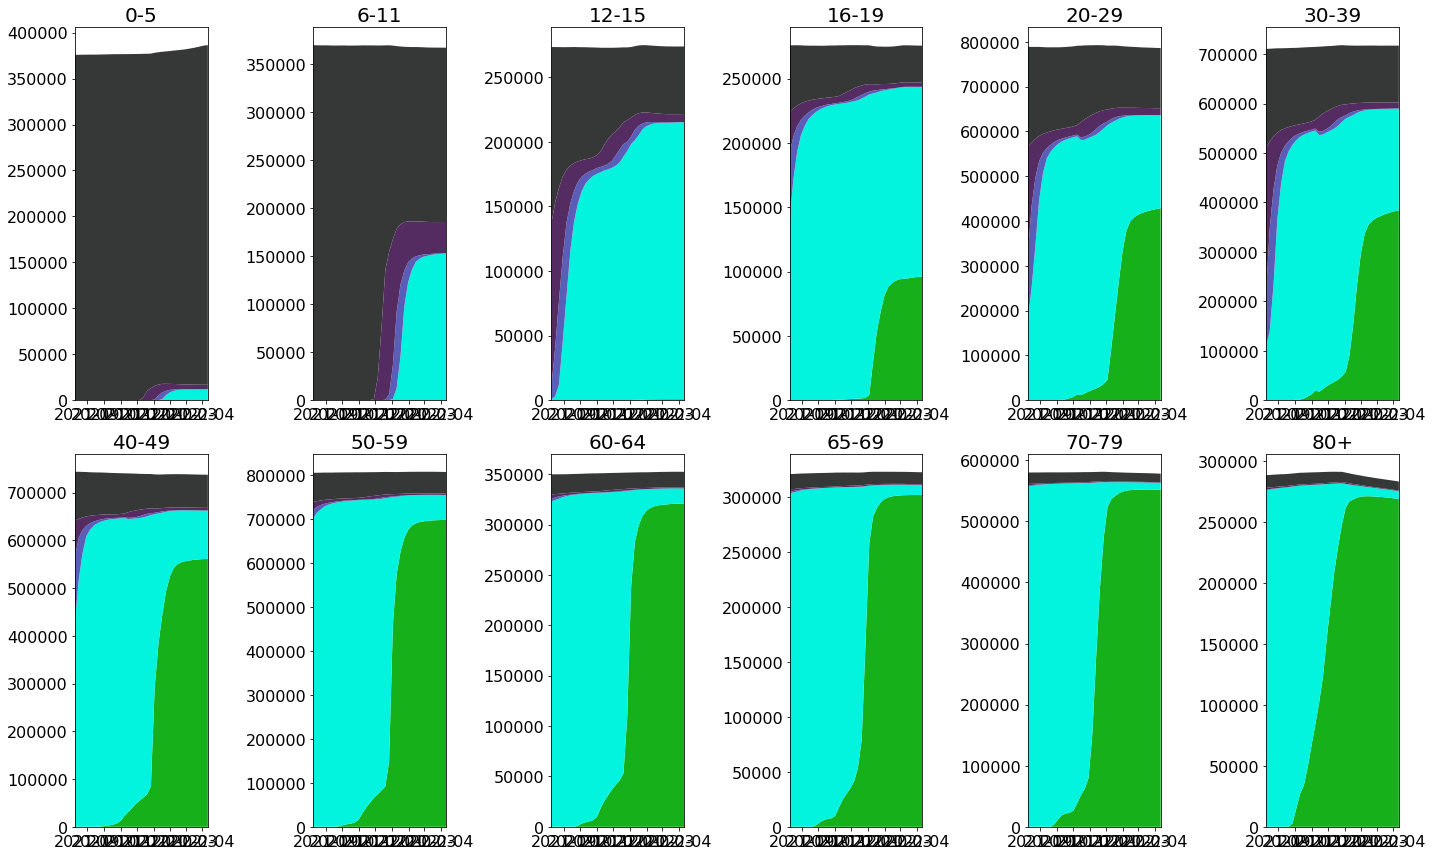

In [36]:

allAges = df_Test_Count.Aldersgruppe.values

curAge = '80+'
curAge = allAges[3]

# fig,ax1 = plt.subplots() 
# fig,allAxes = plt.subplots(len(allAges),1,figsize=(14,20)) 
# fig,allAxes = plt.subplots(2,7,figsize=(20,12)) 
# for i,curAge in enumerate(allAges):

fig,allAxes = plt.subplots(2,6,figsize=(20,12)) 
for i,curAge in enumerate(allAges[:-2]):


    ax1 = allAxes.flatten()[i]

    curPopNone = getPopSizeAll(curStatus=sNone,curAge=curAge)
    curPopOnce = getPopSizeAll(curStatus=sOnce,curAge=curAge)
    curPopBoth = getPopSizeAll(curStatus=sBoth,curAge=curAge)
    curPopFull = getPopSizeAll(curStatus=sFull,curAge=curAge)
    curPopReva = getPopSizeAll(curStatus=sReva,curAge=curAge)

    curPopTwo = curPopBoth-curPopFull-curPopReva


    ax1.stackplot(curDTs,
            curPopReva,
            curPopFull,
            curPopTwo,
            curPopOnce,
            curPopNone,
            colors=[cmap(0),cmap(2),cmap(4),cmap(6),cmap(8)]
            # colors=[cmap(8),cmap(6),cmap(4),cmap(2),cmap(0)]
        )
    ax1.set_title(curAge)

    ax1.set_xlim([curDTs[0],curDTs[-1]])

fig.tight_layout()

In [52]:
df_Hosp_Count

,Aldersgruppe,Uge 15-2022_Ingen vaccination,Uge 15-2022_Første vaccination,Uge 15-2022_Anden vaccination,Uge 15-2022_Fuld effekt efter primært forløb,Uge 15-2022_Fuld effekt efter revaccination,Uge 14-2022_Ingen vaccination,Uge 14-2022_Første vaccination,Uge 14-2022_Anden vaccination,Uge 14-2022_Fuld effekt efter primært forløb,...,Uge 33-2021_Ingen vaccination,Uge 33-2021_Første vaccination,Uge 33-2021_Anden vaccination,Uge 33-2021_Fuld effekt efter primært forløb,Uge 33-2021_Fuld effekt efter revaccination,Uge 32-2021_Ingen vaccination,Uge 32-2021_Første vaccination,Uge 32-2021_Anden vaccination,Uge 32-2021_Fuld effekt efter primært forløb,Uge 32-2021_Fuld effekt efter revaccination
0,0-5,17,0,0,0,0,24,0,0,0,...,12,0,0,0,0,11,0,0,0,0
1,6-11,0,0,0,0,0,0,0,1,1,...,2,0,0,0,0,1,0,0,0,0
2,12-15,0,0,0,0,0,0,0,1,1,...,2,0,0,0,0,4,1,0,0,0
3,16-19,0,0,1,1,0,2,0,3,1,...,6,0,1,0,0,3,1,1,1,0
4,20-29,6,0,25,14,11,2,0,29,10,...,35,0,0,0,0,25,8,1,1,0
5,30-39,6,1,19,8,11,10,1,27,8,...,32,5,2,2,0,30,7,1,0,0
6,40-49,3,0,17,4,13,8,1,25,7,...,27,2,8,7,0,21,9,5,3,0
7,50-59,4,0,34,7,27,7,0,59,5,...,18,2,6,6,0,10,2,5,5,0
8,60-64,3,1,33,1,32,4,0,43,4,...,7,2,6,6,0,7,1,2,2,0
9,65-69,3,0,39,4,35,4,0,68,4,...,2,1,8,8,0,2,0,3,3,0


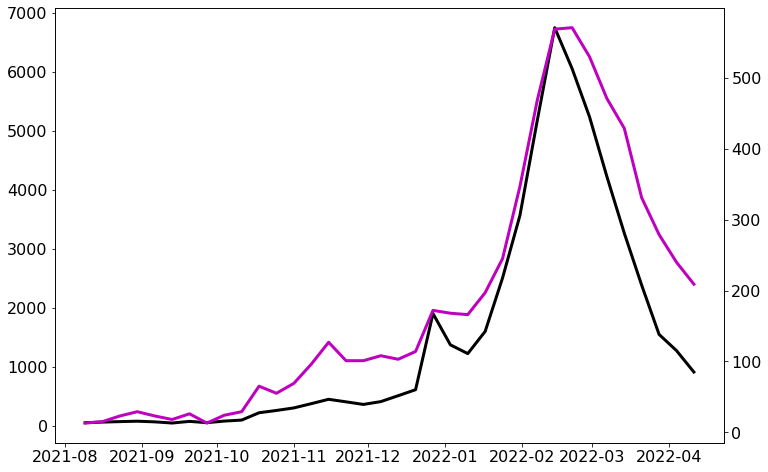

In [98]:
fig,ax = plt.subplots() 
ax2 = ax.twinx() 

thisAge = '16-19'
# thisAge = '20-29'
# thisAge = '10-19'
# thisAge = '40-49'
# thisAge = '50-59'
thisAge = '80+'
hospCount = getTimeSeriesAll(df_Hosp_Count,curAge=thisAge) 
caseCount = getTimeSeriesAll(df_Case_Count,curAge=thisAge) 

ax.plot(curDTs,caseCount,'k')
ax2.plot(curDTs,hospCount,'m')



In [61]:
def rollSum(curArray,rollWidth = 2):
    curRoll = []
    for x in range(rollWidth-1,len(curArray)):
        curRoll.append(curArray[x+1-rollWidth:x+1].sum())
    curRoll = np.array(curRoll)
    return(curRoll)
# rollSum(caseCount) 

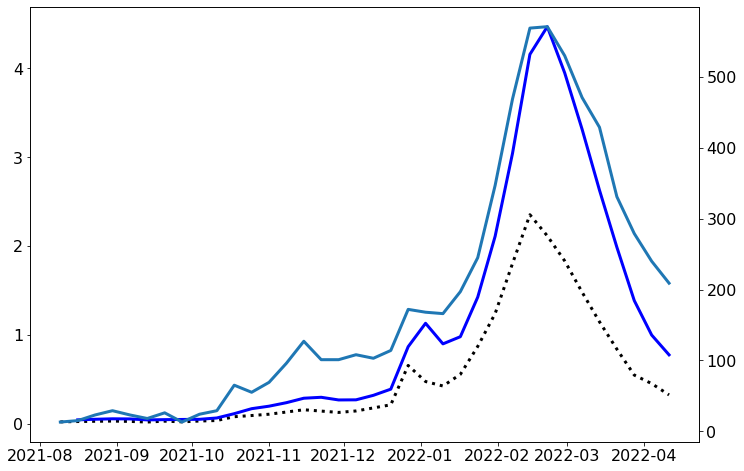

In [99]:
fig,ax = plt.subplots() 
ax2 = ax.twinx() 

thisAge = '16-19'
thisAge = '20-29'
# thisAge = '10-19'
thisAge = '40-49'
# thisAge = '50-59'
# thisAge = '50-9'
thisAge = '80+'

curPop = getPopSizeAll(sNone,curAge=thisAge)+ getPopSizeAll(sOne,curAge=thisAge)+ getPopSizeAll(sTwo,curAge=thisAge)
hospCount = getTimeSeriesAll(df_Hosp_Count,curAge=thisAge) 
caseCount = getTimeSeriesAll(df_Case_Count,curAge=thisAge) 
ax.plot(curDTs,100*caseCount/curPop,'k:')
ax.plot(curDTs[1:],100*rollSum(caseCount)/curPop[1:],'b')

ax2.plot(curDTs,hospCount)


(0.0, 340.1011451547247)

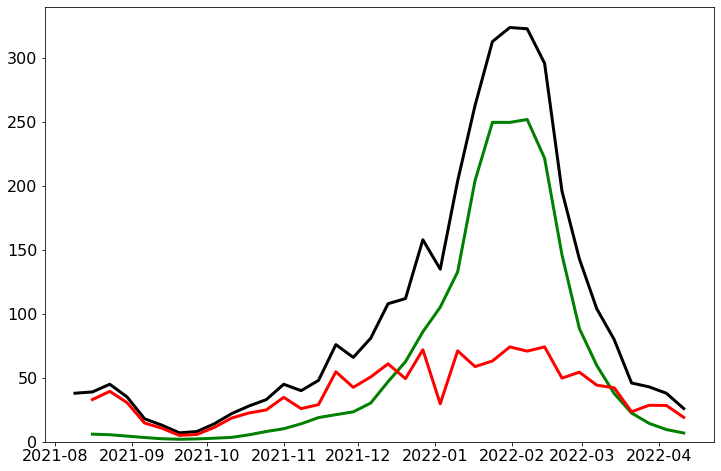

In [105]:
fig,ax = plt.subplots() 

thisAge = '16-19'
thisAge = '20-29'
thisAge = '30-39'
# thisAge = '10-19'
# thisAge = '40-49'
# # thisAge = '50-59'
# # thisAge = '50-9'
# thisAge = '80+'

curPop = getPopSizeAll(sNone,curAge=thisAge)+ getPopSizeAll(sOne,curAge=thisAge)+ getPopSizeAll(sTwo,curAge=thisAge)
hospCount = getTimeSeriesAll(df_Hosp_Count,curAge=thisAge) 
caseCount = getTimeSeriesAll(df_Case_Count,curAge=thisAge) 

weeklyAdmissions = (40685+59266)/52 # DK statistik for 20-29 årige
weeklyAdmissions = (58413+45903)/52 # DK statistik for 30-39 årige
# weeklyAdmissions = 95000/52 # DK statistik for 40-49 årige
# weeklyAdmissions = (103700+125271)/52 # DK statistik for 80+ årige
# https://www.statistikbanken.dk/statbank5a/SelectVarVal/Define.asp?MainTable=IND01&PLanguage=0&PXSId=0&wsid=cftree

# ax.plot(curDTs,weeklyAdmissions*caseCount/curPop,'k:')
ax.plot(curDTs[1:],weeklyAdmissions*rollSum(caseCount)/curPop[1:],'g')
# ax.plot(curDTs[2:],weeklyAdmissions*rollSum(caseCount,rollWidth=3)/curPop[2:],'r')
ax.plot(curDTs,hospCount,'k')

ax.plot(curDTs[1:],hospCount[1:]-(weeklyAdmissions*rollSum(caseCount)/curPop[1:]),'r')

ax.set_ylim(bottom=0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 48332.4)

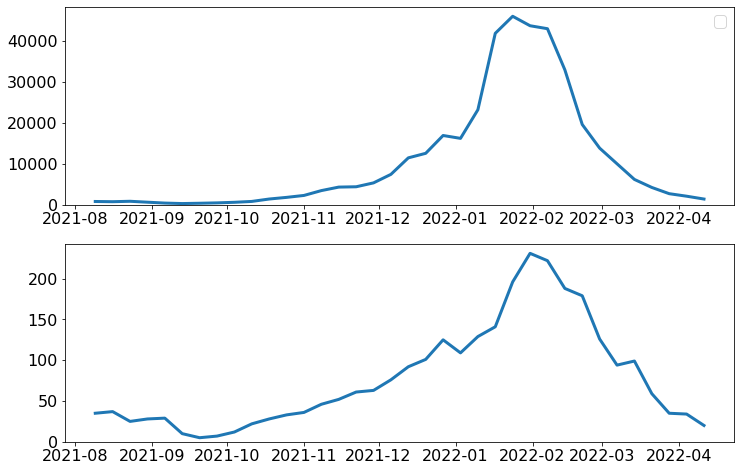

In [43]:
# getTimeSeries(df_Hosp_Inci,curStatus=thisStatus,curAge=thisAge)
fig,(ax,ax2) = plt.subplots(2,1)
thisAge = '50-59'
thisAge = '40-49'
hospCount = getTimeSeriesAll(df_Hosp_Count,curAge=thisAge) 
caseCount = getTimeSeriesAll(df_Case_Count,curAge=thisAge) 
    
ax.plot(curDTs,caseCount)
ax2.plot(curDTs,hospCount)
ax.legend()
ax2.set_ylim(bottom=0)
ax.set_ylim(bottom=0)

(0.0, 100.0)

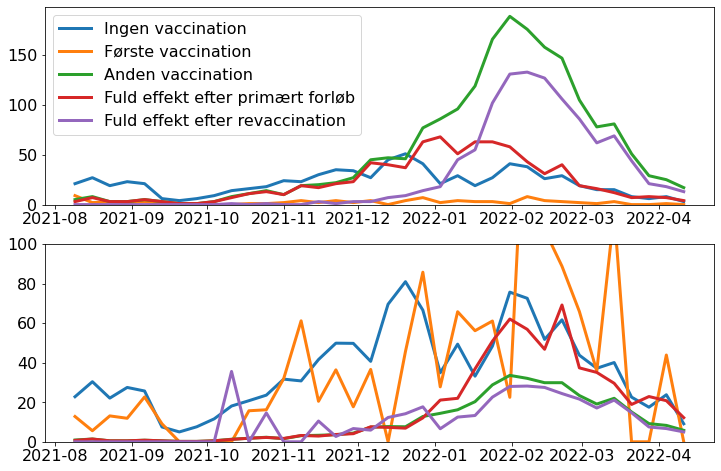

In [ ]:
fig,(ax,ax2) = plt.subplots(2,1)
thisAge = '50-59'
thisAge = '40-49'
for thisStatus in allS:
    hospCount = getTimeSeries(df_Hosp_Count,curStatus=thisStatus,curAge=thisAge) 
    hospInci = getTimeSeries(df_Hosp_Inci,curStatus=thisStatus,curAge=thisAge)
    
    ax.plot(curDTs,hospCount,label=thisStatus)
    ax2.plot(curDTs,hospInci,label=thisStatus)
ax.legend()
ax.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
ax2.set_ylim(top=100)

C:\Users\Rasmus\AppData\Local\Temp/ipykernel_8104/3844038699.py:4: RuntimeWarning: invalid value encountered in true_divide
  toReturn = 100000*curCount/curInci
C:\Users\Rasmus\AppData\Local\Temp/ipykernel_8104/1115342765.py:4: RuntimeWarning: invalid value encountered in true_divide
  toReturn = 100000*curCount/curInci
C:\Users\Rasmus\AppData\Local\Temp/ipykernel_8104/1472465413.py:16: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(curDTs,100*(popAll-popNeg)/popAll,label=thisStatus)


(0.0, 104.91977639086245)

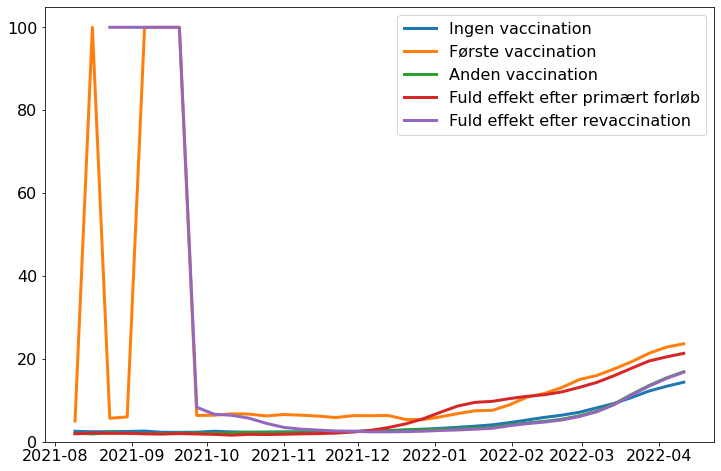

In [ ]:

fig,ax = plt.subplots()

# ax.fill_between(curDTs,popAll)
# # ax.fill_between(curDTs,popNeg)
# ax.fill_between(curDTs,popAll-popNeg)


thisStatus = sReva

for thisStatus in allS:
    thisAge = '80+'
    # thisAge = '20-29'
    popAll = getPopSizeAll(curStatus=thisStatus,curAge=thisAge) 
    popNeg = getPopSizeCount(curStatus=thisStatus,curAge=thisAge)

    ax.plot(curDTs,100*(popAll-popNeg)/popAll,label=thisStatus)
    
    # ax.plot(curDTs,popAll-popNeg,label=thisStatus)

ax.legend()

ax.set_ylim(bottom=0)

In [ ]:
# curCount = getTimeSeries(df_Test_Count)
# curInci  = getTimeSeries(df_Test_Inci)

# curCount
# # curCount/curInci
# fig,ax1 = plt.subplots() 
# ax1.plot(100000*curCount/curInci)
# # df3_T.loc[13,'Uge 01-2022_Ingen vaccination']
# # df_Test_Inci

# ax1.plot(df_main.iloc[-31:,1].values,':')
# # ax1.plot(df_main.iloc[:,1].values,':')
# ax1.set_ylim(bottom=0)

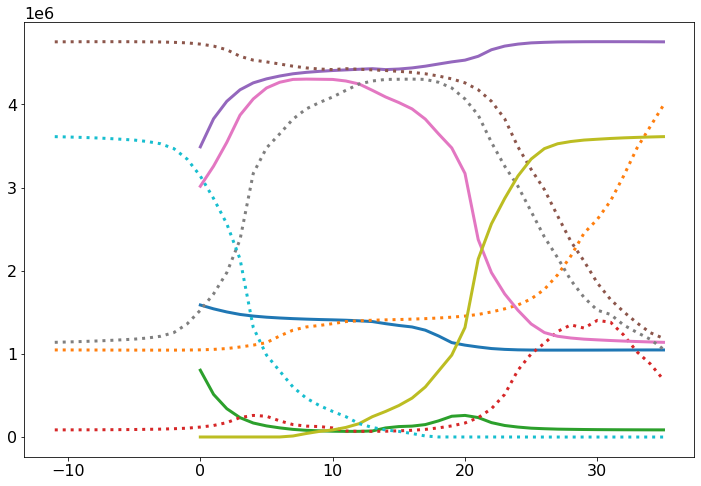

In [ ]:
fig,ax = plt.subplots()

curPop = getPopSizeAll(curStatus=sNone,curAge='Alle')
ax.plot(curPop)
ax.plot(np.arange(len(df_main))-(len(df_main)-len(curPop)),df_main.iloc[:,1].values[::-1],':')

curPop = getPopSizeAll(curStatus=sOne,curAge='Alle')
ax.plot(curPop)
ax.plot(np.arange(len(df_main))-(len(df_main)-len(curPop)),df_main.iloc[:,2].values[::-1],':')

curPop = getPopSizeAll(curStatus=sTwo,curAge='Alle')
ax.plot(curPop)
ax.plot(np.arange(len(df_main))-(len(df_main)-len(curPop)),df_main.iloc[:,3].values[::-1],':')

curPop = getPopSizeAll(curStatus=sFull,curAge='Alle')
ax.plot(curPop)
ax.plot(np.arange(len(df_main))-(len(df_main)-len(curPop)),df_main.iloc[:,4].values[::-1],':')

curPop = getPopSizeAll(curStatus=sReva,curAge='Alle')
ax.plot(curPop)
ax.plot(np.arange(len(df_main))-(len(df_main)-len(curPop)),df_main.iloc[:,5].values[::-1],':')

In [ ]:
# getPopSizeCount() 
# fig,ax = plt.subplots()
# curPop = getPopSizeAll(curStatus=sNone,curAge='Alle')
# ax.plot(curPop)
# curNoPre = getPopSizeCount(curStatus=sNone,curAge='Alle')
# ax.plot(curNoPre)
# ax.plot(curPop-curNoPre)
# ax.plot(np.arange(len(df_main))-(len(df_main)-len(curPop)),df_main.iloc[:,1].values[::-1],':')

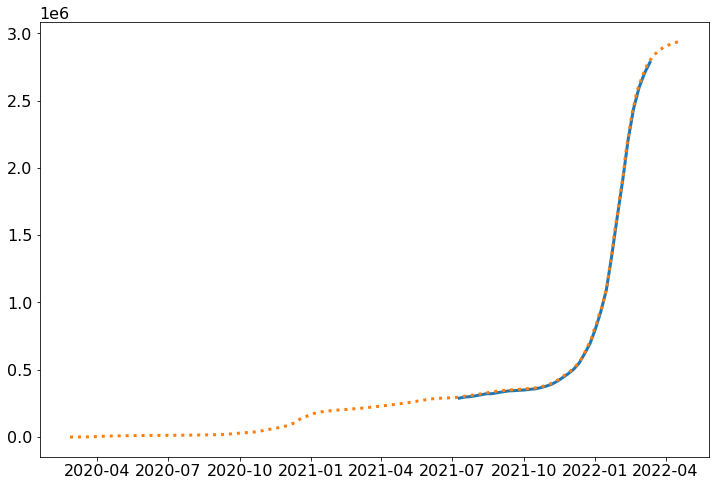

In [ ]:
curPopAll = getPopSizeAll(curStatus=sNone,curAge='Alle') + getPopSizeAll(curStatus=sOne,curAge='Alle') + getPopSizeAll(curStatus=sTwo,curAge='Alle')
curPopNoPre = getPopSizeCount(curStatus=sNone,curAge='Alle') + getPopSizeCount(curStatus=sOne,curAge='Alle') + getPopSizeCount(curStatus=sTwo,curAge='Alle')
# ax.plot(curPop)
# curNoPre = getPopSizeCount(curStatus=sNone,curAge='Alle')
# curPopAll
fig,ax = plt.subplots()
ax.plot(curDTs-np.timedelta64(30,'D'),curPopAll-curPopNoPre)
ax.plot(df_inf.index,np.cumsum(df_inf.infected),':')
# ax.plot(pf.rnTime(df_inf.index),pf.rnMean(df_inf.infected)*7,'xkcd:orange',label='Fra regional_DB filer')

In [ ]:
df_inf.index

DatetimeIndex(['2020-02-26', '2020-02-27', '2020-02-28', '2020-03-01',
               '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05',
               '2020-03-06', '2020-03-07',
               ...
               '2022-04-09', '2022-04-10', '2022-04-11', '2022-04-12',
               '2022-04-13', '2022-04-14', '2022-04-15', '2022-04-16',
               '2022-04-17', '2022-04-18'],
              dtype='datetime64[ns]', name='Prøvedato', length=782, freq=None)

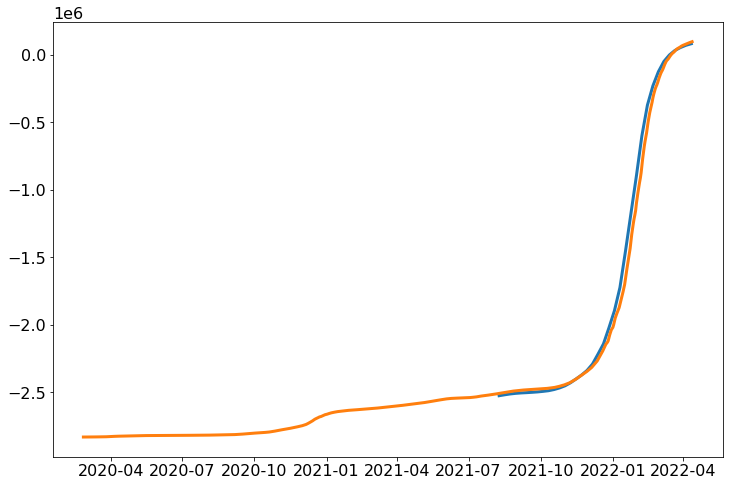

In [ ]:

curCase = getTimeSeries(df_Case_Count,curStatus=sNone) +getTimeSeries(df_Case_Count,curStatus=sOne) + getTimeSeries(df_Case_Count,curStatus=sTwo)
fig,ax = plt.subplots()
# ax.plot(curDTs,curCase)
# ax.plot(pf.rnTime(df_inf.index),pf.rnMean(df_inf.infected)*7,'xkcd:orange',label='Fra regional_DB filer')

realCumu = np.cumsum(df_inf.infected)

realDates = df_inf.index.values[:-6]
realCumu = realCumu[:-6]

curCaseCumu = np.cumsum(curCase)
ax.plot(curDTs,curCaseCumu - curCaseCumu[-5])
ax.plot(realDates,realCumu - realCumu[-28])

In [ ]:
curPopAll = getPopSizeAll(curStatus=sNone,curAge='Alle') + getPopSizeAll(curStatus=sOne,curAge='Alle') + getPopSizeAll(curStatus=sTwo,curAge='Alle')
curPopNoPre = getPopSizeCount(curStatus=sNone,curAge='Alle') + getPopSizeCount(curStatus=sOne,curAge='Alle') + getPopSizeCount(curStatus=sTwo,curAge='Alle')

# fig,ax = plt.subplots()
# ax.plot(curDTs-np.timedelta64(30,'D'),curPopAll-curPopNoPre)


# print(pf.rnMean(curCase,4)*4)

# print(curPopAll-curPopNoPre)
print(curCase)

print(np.diff(np.cumsum(df_inf.infected).values[3::7])[-12:])

[  6798   6788   6168   4413   3181   2149   2476   2979   3998   4980
   8604  11802  15872  22602  27956  28819  34232  47637  73205  76379
 119342 126660 171542 266963 280602 279820 297393 225843 143491 104604
  75971  48100  33351  21515  16671  11862]
[280595 279810 297389 225840 143493 104600  75969  48099  33350  21515
  16671  11862]


In [ ]:
curPosPop = curPopAll-curPopNoPre
print(np.round(curPosPop))
# print(np.cumsum(df_inf.infected).values[3::7][-21:])
print(np.cumsum(df_inf.infected).values[1::7][-13:])

# curPosPop.append(curCase)
asdf = np.append(curPosPop,curPosPop[-1]+(np.cumsum(curCase)-np.cumsum(curCase)[-5])[-4:])
print(np.round(asdf[-12:]))


[ 289121.  297116.  300161.  306296.  314166.  321559.  322220.  329597.
  336080.  342319.  344383.  347361.  349693.  354623.  358459.  367087.
  378626.  392947.  414970.  442019.  470668.  503659.  548887.  618615.
  693987.  804070.  933933. 1093309. 1350093. 1635160. 1907514. 2210620.
 2441336. 2596580. 2703607. 2784518.]
[1324659 1616587 1885972 2190430 2429269 2595426 2706050 2791525 2843500
 2880407 2903948 2921362 2933963]
[1350093. 1635160. 1907514. 2210620. 2441336. 2596580. 2703607. 2784518.
 2817869. 2839384. 2856055. 2867917.]


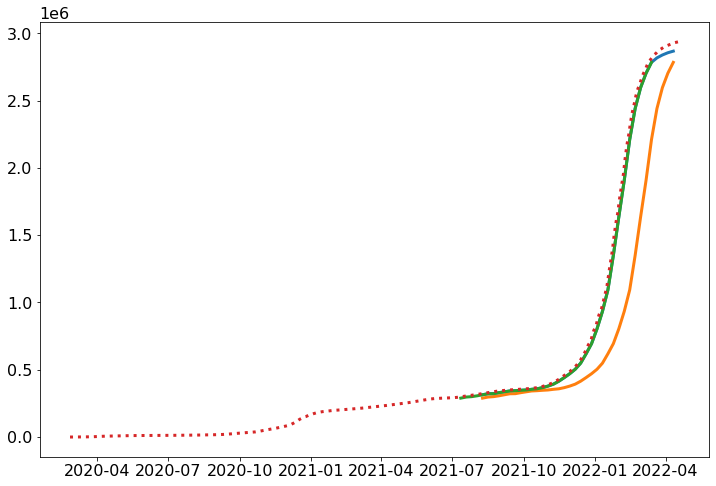

In [ ]:

fig,ax = plt.subplots()
ax.plot(curDTs,asdf[4:])
ax.plot(curDTs,curPosPop)
ax.plot(curDTs-np.timedelta64(28,'D'),curPosPop)
ax.plot(df_inf.index,np.cumsum(df_inf.infected),':')

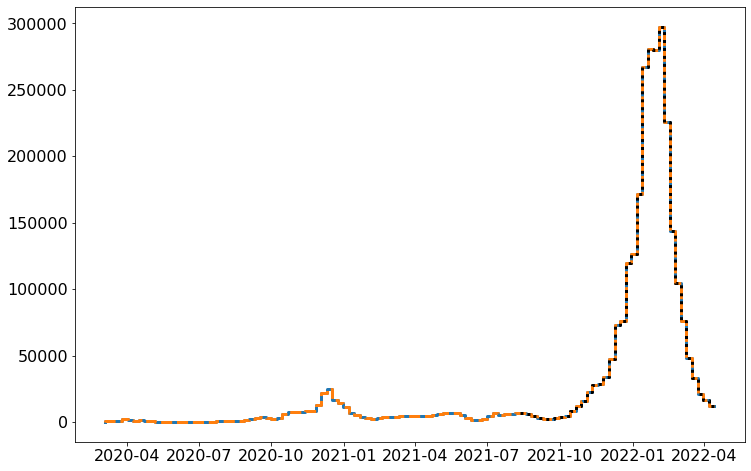

In [ ]:
fig,ax = plt.subplots()
# ax.plot(curDTs,curCase)
# ax.plot(pf.rnTime(df_inf.index,7)[3::7],(pf.rnMean(df_inf.infected,7)*7)[3::7],color='xkcd:orange',label='Fra regional_DB filer')
# ax.step(pf.rnTime(df_inf.index,7)[::7],(pf.rnMean(df_inf.infected,7)*7)[::7],color='xkcd:orange',label='Fra regional_DB filer')
# ax.step(pf.rnTime(df_inf.index,7)[1::7],(pf.rnMean(df_inf.infected,7)*7)[1::7])
# ax.step(pf.rnTime(df_inf.index,7)[2::7],(pf.rnMean(df_inf.infected,7)*7)[2::7])
# ax.step(pf.rnTime(df_inf.index,7)[3::7],(pf.rnMean(df_inf.infected,7)*7)[3::7])
ax.step(pf.rnTime(df_inf.index,7)[4::7],(pf.rnMean(df_inf.infected,7)*7)[4::7])
ax.step(df_inf.index[3:][4::7],(pf.rnMean(df_inf.infected,7)*7)[4::7],'--')
# ax.step(pf.rnTime(df_inf.index,7)[5::7],(pf.rnMean(df_inf.infected,7)*7)[5::7])
# ax.step(pf.rnTime(df_inf.index,7)[6::7],(pf.rnMean(df_inf.infected,7)*7)[6::7])
ax.step(curDTs+np.timedelta64(3,'D'),curCase,color='k',linestyle=':')


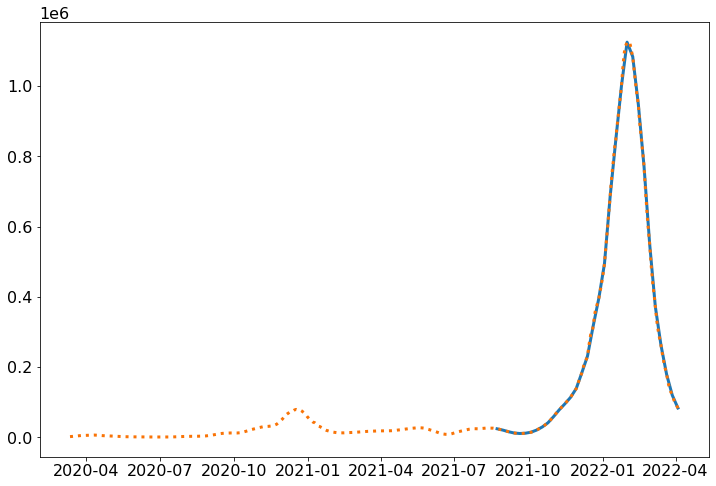

In [ ]:
fig,ax = plt.subplots()
ax.plot(curDTs[2:-1],pf.rnMean(curCase,4)*4)

ax.plot(pf.rnTime(df_inf.index,28),pf.rnMean(df_inf.infected,28)*28,':',color='xkcd:orange',label='Fra regional_DB filer')

In [ ]:

# weekDTs = [np.datetime64(datetime.datetime.strptime(d[-4:] + '-W'+d[4:6]+'-1', "%Y-W%W-%w")) for d in df1.Ugenummer]

# curOrder = np.argsort(weekDTs)
# weekDTs = np.array(weekDTs)
# weekDTs = weekDTs[curOrder]
        
sNone = 'Ingen vaccination'        
sOne = 'Første vaccination'  
sTwo = 'Anden vaccination'
sFull = 'Fuld effekt efter primært forløb'   
sReva = 'Fuld effekt efter revaccination'


ageGroups = df_Test_Inci.Aldersgruppe.values
# print(ageGroups)
# weekNames = df1.Ugenummer
weekNames = df1.Ugenummer.values[curOrder]
weekNamesShort = [x[4:6] for x in weekNames]
wInt = [int(x[4:6]) for x in weekNames]
wIntRange = np.arange(len(wInt))

allDates = np.array(weekDTs)[curOrder]
print(weekNames)

# Make function for gettings particular parts
def getTimeSeriesSingle(thisdf=df2_C,curStatus='Ingen vaccination',curAge='Alle',weekNames=weekNames):
    
    agedf = thisdf[thisdf.Aldersgruppe==curAge]
    allVals = []
    for curWeek in weekNames:
        toAdd = agedf[curWeek+'_'+curStatus].values[0]
        allVals.append(toAdd)
    allVals = np.array(allVals)

    return allVals

    

def getTimeSeries(thisdf=df2_C,curStatus='Ingen vaccination',curAge='Alle',weekNames=weekNames):
    # If curAge is just a string, return the given array
    if (type(curAge)==str):
        agedf = thisdf[thisdf.Aldersgruppe==curAge]
        allVals = []
        for curWeek in weekNames:
            toAdd = agedf[curWeek+'_'+curStatus].values[0]
            allVals.append(toAdd)
        allVals = np.array(allVals)
        
        return allVals 
        
    else:
        # If curAge is not a string, it is assumed to be a list of strings
        totCount = []
        for thisAge in curAge:
            agedf = thisdf[thisdf.Aldersgruppe==thisAge]
            allVals = []
            for curWeek in weekNames:
                toAdd = agedf[curWeek+'_'+curStatus].values[0]
                allVals.append(toAdd)
            allVals = np.array(allVals)
            if len(totCount) == 0:
                totCount = allVals 
            else:
                totCount = totCount + allVals
        return totCount

def getTimeSeriesAll(thisdf=df2_C,curAge='Alle',weekNames=weekNames):
    return getTimeSeries(thisdf,sNone,curAge,weekNames)+getTimeSeries(thisdf,sOne,curAge,weekNames)+getTimeSeries(thisdf,sTwo,curAge,weekNames)

['Uge 21-2021' 'Uge 22' 'Uge 23' 'Uge 24' 'Uge 25' 'Uge 26' 'Uge 27'
 'Uge 28' 'Uge 29' 'Uge 30' 'Uge 31' 'Uge 32' 'Uge 33' 'Uge 34' 'Uge 35'
 'Uge 36']


In [ ]:
# Go through each tuesday, as long back as possible, and grab the last row

# Start by taking all data from the most recent file
df_main = dfRecent.copy()

# allRows = [] 
colNamesToChange = {
'antal_personer_alle_Fuld vaccineeffekt': 'antal_personer_alle_Fuld effekt efter primært forløb',
'antal_personer_Fuld vaccineeffekt': 'antal_personer_Fuld effekt efter primært forløb',
'antal_cases_Fuld vaccineeffekt': 'antal_cases_Fuld effekt efter primært forløb',
'antal_repositive_Fuld vaccineeffekt': 'antal_repositive_Fuld effekt efter primært forløb',
'antal_indlagte_Fuld vaccineeffekt': 'antal_indlagte_Fuld effekt efter primært forløb',
'antal_tests_Fuld vaccineeffekt': 'antal_tests_Fuld effekt efter primært forløb',
'antal_tests_total_Fuld vaccineeffekt': 'antal_tests_total_Fuld effekt efter primært forløb',
}

maxWeeksBack = 50
for k in range(1,maxWeeksBack):
    curTue = mostRecentTuesday - np.timedelta64(7*k,'D')
    curTuePath = 'SSI_data_'+str(curTue)

    dirPath = path_data + curTuePath + '/'
    filePath = dirPath+'gennembrudsinfektioner_table1.csv'
    if os.path.exists(filePath):
        df1 = pd.read_csv(filePath,delimiter=';')
    else:
        continue

    # Check length of "ugenummer" columns
    if (len(df1.iloc[0,0]) == 11):
        # If length is 11, the year was included

        # Figure out order, to be able to get oldest
        weekDTs = [np.datetime64(datetime.datetime.strptime(d[-4:] + '-W'+d[4:6]+'-1', "%Y-W%W-%w")) for d in df1.Ugenummer]
        curOrder = np.argsort(weekDTs)
        df1 = df1.rename(columns=colNamesToChange) 

        oldestIndex = np.where(curOrder == 0)[0][0]
        # print(df1.iloc[oldestIndex,0])
        # display(df1.iloc[oldestIndex,1])

        # allRows.append(df1.iloc[oldestIndex,:])
        # df_main = df_main.append(df1.iloc[oldestIndex,:])
        df_main = pd.concat([df_main,df1.iloc[oldestIndex:oldestIndex+1,:]])
    else:
        # display(df1)

        # Rename weeknumber to have year
        df1.iloc[-1,0] = df1.iloc[-1,0] + '-2021'
        # And rename "Fuld Effekt" columns
        df1 = df1.rename(columns=colNamesToChange) 



        # print(df1.iloc[-1,0])
        # allRows.append(df1.iloc[-1,:])
        # df_main = df_main.append(df1.iloc[-1,:])
        df_main = pd.concat([df_main,df1.iloc[-1:,:]])


In [ ]:
# df2_C/df3_C
case = df2_C.iloc[:,1:4]
inci = df3_C.iloc[:,1:4]
popSizes = 100000*case/inci 
# popSizes.sum(axis=1)
popSizes

# inci/100000
# popSizes
# df3_C.iloc[:,1:4]
# df2_C

case = df2_T.iloc[:,1:4]
inci = df3_T.iloc[:,1:4]
popSizes = 100000*case/inci 
# popSizes.sum(axis=1)
popSizes

,Uge 15-2022_Ingen vaccination,Uge 15-2022_Første vaccination,Uge 15-2022_Anden vaccination
0,3.695349e+05,4895.960832,1.194565e+04
1,1.813410e+05,32357.473035,1.530389e+05
2,5.233220e+04,6118.286880,2.154228e+05
3,2.860107e+04,3403.772515,2.436058e+05
4,1.343239e+05,15327.160974,6.365693e+05
5,1.147787e+05,12356.199403,5.900721e+05
6,6.943765e+04,5513.832113,6.625054e+05
7,4.905051e+04,3197.061424,7.548124e+05
8,1.546729e+04,943.007014,3.359461e+05
9,1.092669e+04,635.985199,3.111056e+05


In [ ]:

dfRecent

,Ugenummer,antal_personer_alle_Ingen vaccination,antal_personer_alle_Første vaccination,antal_personer_alle_Anden vaccination,antal_personer_alle_Fuld effekt efter primært forløb,antal_personer_alle_Fuld effekt efter revaccination,antal_personer_Ingen vaccination,antal_personer_Første vaccination,antal_personer_Anden vaccination,antal_personer_Fuld effekt efter primært forløb,...,antal_repositive_Ingen vaccination,antal_repositive_Første vaccination,antal_repositive_Anden vaccination,antal_repositive_Fuld effekt efter primært forløb,antal_repositive_Fuld effekt efter revaccination,antal_indlagte_Ingen vaccination,antal_indlagte_Første vaccination,antal_indlagte_Anden vaccination,antal_indlagte_Fuld effekt efter primært forløb,antal_indlagte_Fuld effekt efter revaccination
0,Uge 15-2022,1047385,86026,4753138,1139015,3612842,506925,25688,2569706,384336,...,147,14,628,137,491,68,4,529,50,479
1,Uge 14-2022,1047446,86312,4753694,1143343,3608738,512429,26166,2645142,396000,...,209,23,821,209,612,85,5,673,60,613
2,Uge 13-2022,1047035,86772,4754423,1148525,3603912,520876,26935,2743914,412589,...,255,30,936,253,682,87,9,812,84,728
3,Uge 12-2022,1046605,87314,4754760,1154234,3598219,534768,28025,2884397,438357,...,345,35,1472,389,1083,126,12,982,93,889
4,Uge 11-2022,1046159,88124,4754884,1160937,3590973,561281,30244,3087041,483898,...,564,59,2065,570,1494,173,16,1223,130,1093
5,Uge 10-2022,1045738,89050,4754807,1168801,3581710,606672,34196,3341121,560142,...,969,89,3311,1059,2249,207,9,1460,169,1291
6,Uge 09-2022,1045524,90503,4754406,1177259,3571808,657338,39304,3558596,641775,...,1418,106,4320,1470,2840,302,21,1758,235,1522
7,Uge 08-2022,1045338,92638,4753140,1190848,3554236,717991,47415,3775631,737964,...,2010,194,6094,2040,4038,391,34,2033,326,1704
8,Uge 07-2022,1045234,94998,4751522,1212021,3527189,778886,57452,3962111,840266,...,3356,275,9198,3451,5715,550,39,2164,407,1755
9,Uge 06-2022,1045306,99948,4746985,1256354,3468920,819096,66976,4072225,930866,...,5496,411,12068,5102,6893,630,46,2014,508,1499


In [ ]:
# df2_C
# 5333/
# dfRecent
case = 5333
pop = 1038331
pop = 599151
100000*case/pop

100000*case / 890.1
# df3_C

case = df2_C.iloc[:,1:4]
inci = df3_C.iloc[:,1:4] 
100000*case/inci

,Uge 15-2022_Ingen vaccination,Uge 15-2022_Første vaccination,Uge 15-2022_Anden vaccination
0,228033.472803,1644.736842,6.535948e+03
1,43478.260870,5694.760820,5.335628e+04
2,12031.139420,1227.998363,6.358382e+04
3,9708.737864,NaN,7.753706e+04
4,63109.954457,5823.627288,2.873980e+05
5,51936.218679,4250.386399,2.413330e+05
6,33036.182486,2225.932109,2.922519e+05
7,28421.377819,1712.328767,4.323362e+05
8,10464.355788,609.942056,2.177285e+05
9,8429.118774,NaN,2.252865e+05


In [ ]:
# firstAlleIndex = np.where(df_main.columns == 'antal_personer_alle_Ingen vaccination')[0][0]
# totAlle = df_main.iloc[:,firstAlleIndex:firstAlleIndex+3].sum(axis=1)

# firstPersIndex = np.where(df_main.columns == 'antal_personer_Ingen vaccination')[0][0]
# totPers = df_main.iloc[:,firstPersIndex:firstPersIndex+3].sum(axis=1)

# firstCaseIndex = np.where(df_main.columns == 'antal_cases_Ingen vaccination')[0][0]
# totCase = df_main.iloc[:,firstCaseIndex:firstCaseIndex+3].sum(axis=1).values


# fourWeekCase = np.cumsum(totCase[4:])-np.cumsum(totCase[:-4])

# prevPos = np.cumsum(totCase) + (totAlle[0]-totPers[0])

# curPos = prevPos[4:] - prevPos[:-4]

# toShow = np.concatenate([(totAlle-totPers).values[5:],prevPos[-5:]])

# fig,ax1 = plt.subplots()

# # curDif = totAlle-totPers 
# # ax1.plot(allDTs-np.timedelta64(35,'D'),curDif)
# # ax1.plot(allDTs,np.cumsum(totCase)+curDif[0])

# # ax1.plot(allDTs,totAlle-totPers)
# # ax1.plot(allDTs,totAlle-totPers + totCase)
# # ax1.plot(allDTs,totAlle)
# # ax1.plot(allDTs,totPers)
# # ax1.plot(allDTs,totPers+prevPos)
# # ax1.plot(allDTs[5:],totPers[5:]+prevPos[:-5])

# # ax1.plot(allDTs,totAlle-totPers)
# # ax1.plot(allDTs[5:],totAlle[5:]-totPers[5:]+prevPos[:-5])
# ax1.plot(allDTs-np.timedelta64(4*7,'D'),totAlle-totPers)#+np.cumsum(totCase))
# ax1.plot(allDTs,prevPos,'*-')
# ax1.plot(allDTs,toShow)
# ax1.plot(df_inf.index,np.cumsum(df_inf.infected),':',label='Fra regional_DB filer')

# # ax1.plot(allDTs[4:],curPos)
# # ax1.plot(df_inf.index,df_inf.infected,label='Fra regional_DB filer')

# # ax1.plot(allDTs,totPers+totCase,'*-')
# # ax1.plot(allDTs,totAlle-totCase,'*-')
# # ax1.plot(allDTs[4:],totAlle[4:]-fourWeekCase,'*-')
# # ax1.plot(allDTs[4:],totPers[4:]+fourWeekCase)

# # ax1.set_ylim([5.7e6,6.0e6])

# # ax1.plot(allDTs,totCase)
# # ax1.plot(allDTs[4:],np.cumsum(totCase[4:])-np.cumsum(totCase[:-4]))

# Old below

In [ ]:
# # Go through each tuesday, as long back as possible, and grab the last row

# # Start by taking all data from the most recent file
# df_main = dfRecent.copy()

# # allRows = [] 
# colNamesToChange = {
# 'antal_personer_alle_Fuld vaccineeffekt': 'antal_personer_alle_Fuld effekt efter primært forløb',
# 'antal_personer_Fuld vaccineeffekt': 'antal_personer_Fuld effekt efter primært forløb',
# 'antal_cases_Fuld vaccineeffekt': 'antal_cases_Fuld effekt efter primært forløb',
# 'antal_repositive_Fuld vaccineeffekt': 'antal_repositive_Fuld effekt efter primært forløb',
# 'antal_indlagte_Fuld vaccineeffekt': 'antal_indlagte_Fuld effekt efter primært forløb',
# 'antal_tests_Fuld vaccineeffekt': 'antal_tests_Fuld effekt efter primært forløb',
# 'antal_tests_total_Fuld vaccineeffekt': 'antal_tests_total_Fuld effekt efter primært forløb',
# }

# maxWeeksBack = 50
# for k in range(1,maxWeeksBack):
#     curTue = mostRecentTuesday - np.timedelta64(7*k,'D')
#     curTuePath = 'SSI_data_'+str(curTue)

#     dirPath = path_data + curTuePath + '/'
#     filePath = dirPath+'gennembrudsinfektioner_table1.csv'
#     if os.path.exists(filePath):
#         df1 = pd.read_csv(filePath,delimiter=';')
#     else:
#         continue

#     # Check length of "ugenummer" columns
#     if (len(df1.iloc[0,0]) == 11):
#         # If length is 11, the year was included

#         # Figure out order, to be able to get oldest
#         weekDTs = [np.datetime64(datetime.datetime.strptime(d[-4:] + '-W'+d[4:6]+'-1', "%Y-W%W-%w")) for d in df1.Ugenummer]
#         curOrder = np.argsort(weekDTs)
#         df1 = df1.rename(columns=colNamesToChange) 

#         oldestIndex = np.where(curOrder == 0)[0][0]
#         # print(df1.iloc[oldestIndex,0])
#         # display(df1.iloc[oldestIndex,1])

#         # allRows.append(df1.iloc[oldestIndex,:])
#         # df_main = df_main.append(df1.iloc[oldestIndex,:])
#         df_main = pd.concat([df_main,df1.iloc[oldestIndex:oldestIndex+1,:]])
#     else:
#         # display(df1)

#         # Rename weeknumber to have year
#         df1.iloc[-1,0] = df1.iloc[-1,0] + '-2021'
#         # And rename "Fuld Effekt" columns
#         df1 = df1.rename(columns=colNamesToChange) 



#         # print(df1.iloc[-1,0])
#         # allRows.append(df1.iloc[-1,:])
#         # df_main = df_main.append(df1.iloc[-1,:])
#         df_main = pd.concat([df_main,df1.iloc[-1:,:]])


In [ ]:
# # unva = df_main.iloc[:,1]
# unva_neg =  df_main.iloc[:,6]
# once_neg =  df_main.iloc[:,7]
# both_neg =  df_main.iloc[:,8]
# full_neg =  df_main.iloc[:,9].fillna(0) +  df_main.iloc[:,-5].fillna(0)
# reva_neg =  df_main.iloc[:,10]

# unva_pos = unva - df_main.iloc[:,6]
# once_pos = once - df_main.iloc[:,7]
# both_pos = both - df_main.iloc[:,8]
# full_pos = full - df_main.iloc[:,9].fillna(0) -  df_main.iloc[:,-5].fillna(0)
# reva_pos = reva - df_main.iloc[:,10]

# # unva = df_main.iloc[:,1]
# # once = df_main.iloc[:,2]
# # both = df_main.iloc[:,3]
# # full_pri = df_main.iloc[:,4].fillna(0)
# # full_old = df_main.iloc[:,-4].fillna(0)
# # full = full_pri + full_old
# # reva = df_main.iloc[:,5].fillna(0)



# fig,(ax1,ax2) = plt.subplots(2,1,sharex=True)
# # ax1.fill_between(allDTs,unva)
# # ax1.fill_between(allDTs,unva_pos)
# # ax2.fill_between(allDTs,unva/unva)
# # ax2.fill_between(allDTs,unva_pos/unva)

# # ax1.fill_between(allDTs,once)
# # ax1.fill_between(allDTs,once_pos)
# # ax2.fill_between(allDTs,once/once)
# # ax2.fill_between(allDTs,once_pos/once)


# # ax1.fill_between(allDTs,both)
# # ax1.fill_between(allDTs,both_pos)
# # ax2.fill_between(allDTs,both/both)
# # ax2.fill_between(allDTs,both_pos/both)


# ax1.fill_between(allDTs,reva)
# ax1.fill_between(allDTs,reva_pos)
# ax2.fill_between(allDTs,reva/reva)
# ax2.fill_between(allDTs,reva_pos/reva)

# ax1.set_ylim(bottom=0)

In [ ]:

# cmap = pf.getColormapFromList(['xkcd:green','xkcd:cyan','xkcd:purple','xkcd:dark grey'],8)
# allLabels= ['Booster,\nprevious infection','Booster,\nno known infection','Two doses,\nprevious infection','Two doses,\nno known infection','One dose,\nprevious infection','One dose,\nno known infection','Unvaccinated,\nprevious infection','Unvaccinated,\nno known infection']
# fig,ax1 = plt.subplots()
# ax1.stackplot(allDTs,
#                 100*(reva_pos)/popSize,
#                 100*(reva_neg)/popSize,
#                 # 100*(full_pos)/popSize,
#                 # 100*(full_neg)/popSize,
#                 # 100*(both_pos-full_pos-reva_pos)/popSize,
#                 # 100*(both_neg-full_neg-reva_neg)/popSize,
#                 100*(both_pos-reva_pos)/popSize,
#                 100*(both_neg-reva_neg)/popSize,
#                 100*(once_pos)/popSize,
#                 100*(once_neg)/popSize,
#                 100*(unva_pos)/popSize,
#                 100*(unva_neg)/popSize,
#                 # colors=['xkcd:dark green','xkcd:green','xkcd:cyan','xkcd:blue','m'],
#                 # labels=['Full effect after booster','Full effect after two doses','Two doses','One dose','Unvaccinated']
#                 colors = [cmap(k) for k in range(0,8)],
#                 labels= allLabels 
#         )
        
# ax1.set_ylim([0,100])
# # ax1.legend(loc='upper left')
# # ax1.legend(bbox_to_anchor=(1.05,0.5),loc='center left')
# ax1.legend(bbox_to_anchor=(-0.05,0.5),loc='center right')

# ax1.set_xlim([np.min(allDTs),np.max(allDTs)])

# ax1.yaxis.set_label_position("right")
# ax1.yaxis.tick_right()


# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

# fig.tight_layout()

# fig.savefig(path_figs+'Immunity/TotalPopulationImmunity')

In [ ]:
# fig,ax1 = plt.subplots()
# ax1.plot(allDTs,100*(reva_pos)/popSize,label='reva_pos')
# ax1.plot(allDTs,100*(both_pos-reva_pos)/popSize,label='both_pos')
# ax1.plot(allDTs,100*(once_pos)/popSize,label='once_pos')
# ax1.plot(allDTs,100*(unva_pos)/popSize,label='unva_pos')
# ax1.legend()

In [ ]:
# curStatus = 'Ingen vaccination'
# curdf = df_main[::-1]
# curDates = allDTs[::-1]
# curAlle = curdf['antal_personer_alle_'+curStatus]
# curPers = curdf['antal_personer_'+curStatus]
# curCase = curdf['antal_cases_'+curStatus]
# curRepo = curdf['antal_repositive_'+curStatus]

# fig,ax1 = plt.subplots()

# ax1.plot(curDates,curAlle)
# ax1.plot(curDates,curPers)
# ax1.plot(curDates,curCase)
# ax1.plot(curDates,curRepo)


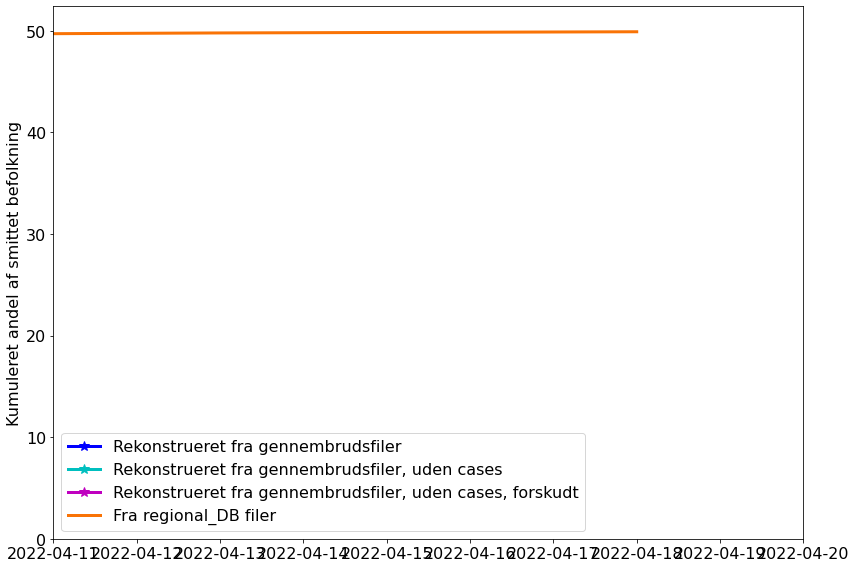

In [ ]:

curdf = df_main[::-1]
curDates = allDTs[::-1]


alleSum = curdf.iloc[:,1:4].sum(axis=1).values
antalSum = curdf.iloc[:,6:9].sum(axis=1).values
antalCase = curdf.iloc[:,11:14].sum(axis=1).values
curPosi = np.cumsum(antalCase)[4:] -  np.cumsum(antalCase)[:-4]

# fig,ax1 = plt.subplots()
# ax1.plot(curDates,antalCase)
# ax1.plot(curDates[4:],curPosi)

antalRepo = curdf.iloc[:,31:34].sum(axis=1).values
curRepo = np.cumsum(antalRepo)[4:] -  np.cumsum(antalRepo)[:-4]

# fig,ax1 = plt.subplots()
# ax1.plot(curDates,antalRepo)
# ax1.plot(curDates[4:],curRepo)

fig,ax1 = plt.subplots()

allPos = alleSum[4:] - antalSum[4:] + curPosi - curRepo
ax1.plot(curDates[4:],100*allPos/alleSum[4:],'b*-',label='Rekonstrueret fra gennembrudsfiler')
ax1.plot(curDates[4:],100*(alleSum[4:] - antalSum[4:])/alleSum[4:],'c*-',label='Rekonstrueret fra gennembrudsfiler, uden cases')
ax1.plot(curDates[4:]-np.timedelta64(30,'D'),100*(alleSum[4:] - antalSum[4:])/alleSum[4:],'m*-',label='Rekonstrueret fra gennembrudsfiler, uden cases, forskudt')

# allPosRepo = alleSum[4:] - antalSum[4:] + curPosi + curRepo
# ax1.plot(curDates[4:],100*allPosRepo/alleSum[4:],'*-',color='xkcd:cyan')



dkPop = popSize.values[-1]
ax1.plot(df_inf.index,100*np.cumsum(df_inf.infected)/dkPop,'xkcd:orange',label='Fra regional_DB filer')
# ax1.plot(df_inf.index+np.timedelta64(30,'D'),100*np.cumsum(df_inf.infected)/dkPop,'r:',label='Cumulative sum\nof all cases,\nshifted 30 days forward')


ax1.set_xlim([curDates[0],np.datetime64('today')])
ax1.legend()

ax1.set_ylabel('Kumuleret andel af smittet befolkning')

ax1.set_ylim(bottom=0)
fig.tight_layout()

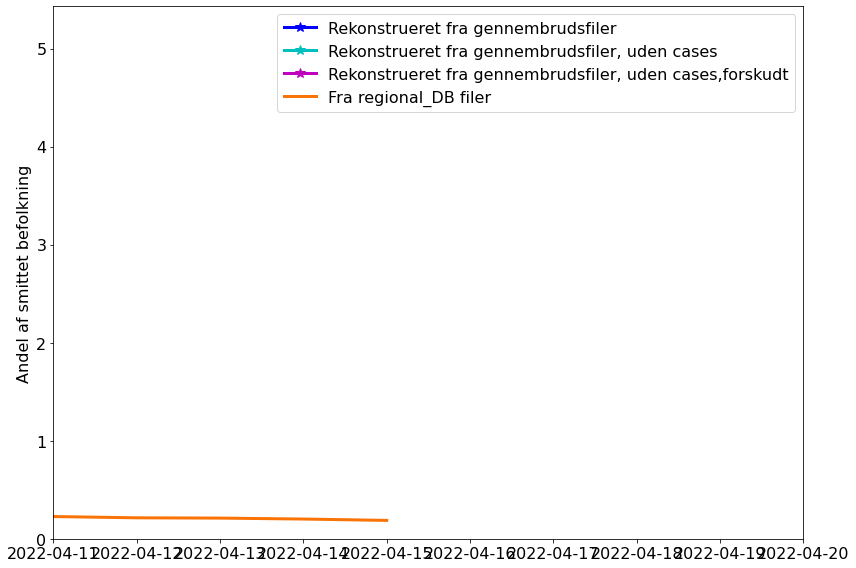

In [ ]:
fig,ax1 = plt.subplots() 


allPos = alleSum[4:] - antalSum[4:] + curPosi + curRepo
ax1.plot(curDates[5:],100*np.diff(allPos)/alleSum[5:],'b*-',label='Rekonstrueret fra gennembrudsfiler')
ax1.plot(curDates[5:],100*np.diff(alleSum[4:] - antalSum[4:])/alleSum[5:],'c*-',label='Rekonstrueret fra gennembrudsfiler, uden cases')
ax1.plot(curDates[5:]-np.timedelta64(30,'D'),100*np.diff(alleSum[4:] - antalSum[4:])/alleSum[5:],'m*-',label='Rekonstrueret fra gennembrudsfiler, uden cases,forskudt')
# ax1.step(curDates[5:],100*np.diff(allPos)/alleSum[5:],color='b',label='Rekonstrueret fra gennembrudsfiler',where='post')
# ax1.step(curDates[5:],100*np.diff(alleSum[4:] - antalSum[4:])/alleSum[5:],color='c',label='Rekonstrueret fra gennembrudsfiler, uden cases',where='pre')
# ax1.step(curDates[5:]-np.timedelta64(30,'D'),100*np.diff(alleSum[4:] - antalSum[4:])/alleSum[5:],color='m',label='Rekonstrueret fra gennembrudsfiler, uden cases, forskudt',where='pre')


dkPop = popSize.values[-1]
ax1.plot(pf.rnTime(df_inf.index),7*100*pf.rnMean(df_inf.infected)/dkPop,'xkcd:orange',label='Fra regional_DB filer')
# # ax1.plot(df_inf.index+np.timedelta64(30,'D'),100*np.cumsum(df_inf.infected)/dkPop,'r:',label='Cumulative sum\nof all cases,\nshifted 30 days forward')


ax1.set_xlim([curDates[0],np.datetime64('today')])
ax1.legend()

ax1.set_ylabel('Andel af smittet befolkning')

ax1.set_ylim(bottom=0)
fig.tight_layout()

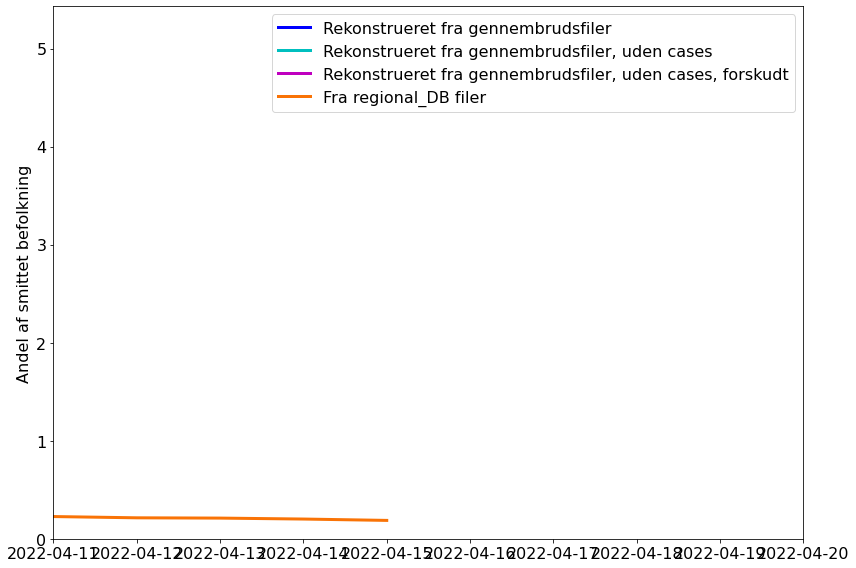

In [ ]:
fig,ax1 = plt.subplots() 


allPos = alleSum[4:] - antalSum[4:] + curPosi + curRepo
# ax1.plot(curDates[5:],100*np.diff(allPos)/alleSum[5:],'b*-',label='Rekonstrueret fra gennembrudsfiler')
# ax1.plot(curDates[5:],100*np.diff(alleSum[4:] - antalSum[4:])/alleSum[5:],'c*-',label='Rekonstrueret fra gennembrudsfiler, uden cases')
ax1.step(curDates[5:],100*np.diff(allPos)/alleSum[5:],color='b',label='Rekonstrueret fra gennembrudsfiler',where='post')
ax1.step(curDates[5:],100*np.diff(alleSum[4:] - antalSum[4:])/alleSum[5:],color='c',label='Rekonstrueret fra gennembrudsfiler, uden cases',where='pre')
ax1.step(curDates[5:]-np.timedelta64(30,'D'),100*np.diff(alleSum[4:] - antalSum[4:])/alleSum[5:],color='m',label='Rekonstrueret fra gennembrudsfiler, uden cases, forskudt',where='pre')


dkPop = popSize.values[-1]
ax1.plot(pf.rnTime(df_inf.index),7*100*pf.rnMean(df_inf.infected)/dkPop,'xkcd:orange',label='Fra regional_DB filer')
# # ax1.plot(df_inf.index+np.timedelta64(30,'D'),100*np.cumsum(df_inf.infected)/dkPop,'r:',label='Cumulative sum\nof all cases,\nshifted 30 days forward')


ax1.set_xlim([curDates[0],np.datetime64('today')])
ax1.legend()

ax1.set_ylabel('Andel af smittet befolkning')

ax1.set_ylim(bottom=0)
fig.tight_layout()

In [ ]:
# alleSum = df_main.iloc

alleSum = df_main.iloc[:,1:4].sum(axis=1)
antalSum = df_main.iloc[:,6:9].sum(axis=1)
antalCase = df_main.iloc[:,11:14].sum(axis=1)
antalCase
curPosi = np.cumsum(antalCase)
curPosi


# fig,ax1 = plt.subplots()

# # ax1.plot(allDTs,alleSum)
# # ax1.plot(allDTs,antalSum)
# ax1.plot(allDTs,(alleSum-antalSum)/alleSum)
# # ax1.plot(allDTs,np.diff((alleSum-antalSum)/alleSum)


# # Antal_personer_alle - Antal_personer + fire ugers cases - fire ugers repositive

0       11862
1       28533
2       50048
3       83399
4      131499
5      207470
6      312074
7      455565
8      681408
9      978801
10    1258621
11    1539223
12    1806186
13    1977728
14    2104388
15    2223730
15    2300109
15    2373314
15    2420951
15    2455183
15    2484002
15    2511958
15    2534560
15    2550432
15    2562234
15    2570838
15    2575818
15    2579816
13    2582795
14    2585271
15    2587420
15    2590601
15    2595014
15    2601182
15    2607970
15    2614768
15    2621064
15    2627266
15    2632507
15    2639289
15    2643870
15    2646526
15    2647819
15    2649454
15    2651628
15    2656252
15    2662061
dtype: int64

In [ ]:
unva_case = df_main['antal_cases_Ingen vaccination'].values[::-1]
once_case = df_main['antal_cases_Første vaccination'].values[::-1]
both_case = df_main['antal_cases_Anden vaccination'].values[::-1]
full_case = df_main['antal_cases_Fuld effekt efter primært forløb'].values[::-1]
reva_case = df_main['antal_cases_Fuld effekt efter revaccination'].values[::-1]


unva_case_cumsum = np.cumsum(df_main['antal_cases_Ingen vaccination'].values[::-1])
once_case_cumsum = np.cumsum(df_main['antal_cases_Første vaccination'].values[::-1])
both_case_cumsum = np.cumsum(df_main['antal_cases_Anden vaccination'].values[::-1])
full_case_cumsum = np.cumsum(df_main['antal_cases_Fuld effekt efter primært forløb'].values[::-1])
reva_case_cumsum = np.cumsum(df_main['antal_cases_Fuld effekt efter revaccination'].values[::-1])
# df_main.columns[11:]

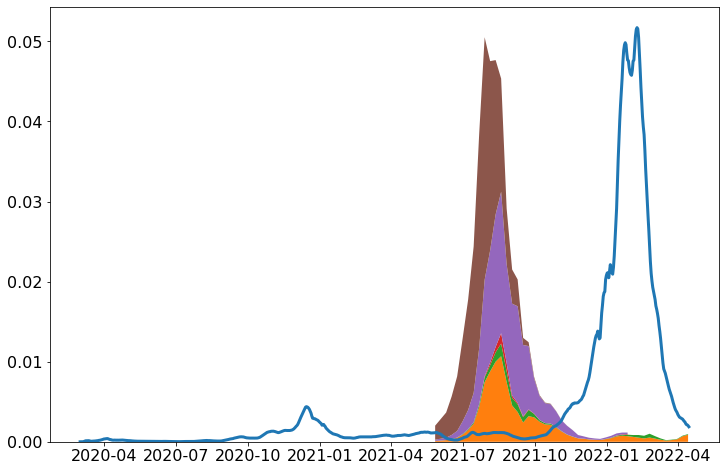

In [ ]:
fig,ax1 = plt.subplots() 
dkPop = popSize.values[-1]
dates = allDTs[::-1]
ax1.plot(pf.rnTime(df_inf.index),7*pf.rnMean(df_inf.infected/dkPop))
# ax1.plot(df_reinf.index,df_reinf.infected/dkPop+df_inf.infected/dkPop)

# ax1.plot(dates,unva_case/dkPop)
ax1.stackplot(dates+np.timedelta64(3,'D'),
                unva_case/dkPop,
                once_case/dkPop,
                (both_case-full_case-reva_case)/dkPop,
                full_case/dkPop,
                reva_case/dkPop
        )

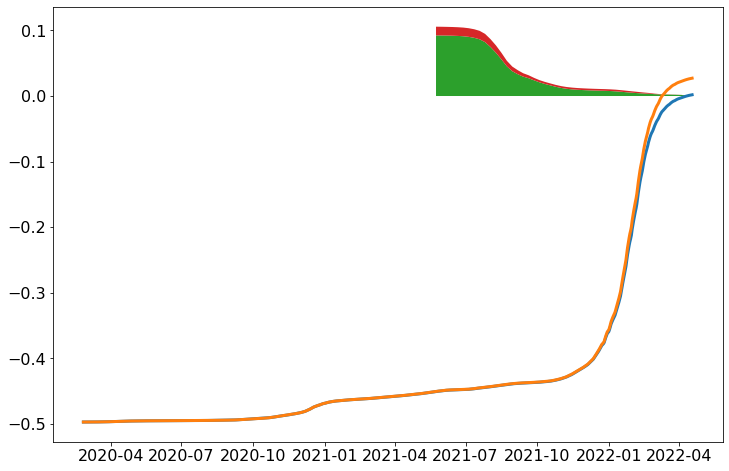

In [ ]:
fig,ax1 = plt.subplots() 
dkPop = popSize.values[-1]
dates = allDTs[::-1]

iniInfIndex = np.where(df_inf.index == dates[0])[0][0]
iniInf = (np.cumsum(df_inf.infected)/dkPop)[iniInfIndex]
ax1.plot(df_inf.index,np.cumsum(df_inf.infected)/dkPop - iniInf)
ax1.plot(df_reinf.index,np.cumsum(df_reinf.infected)/dkPop+np.cumsum(df_inf.infected)/dkPop - iniInf)

# ax1.plot(dates,unva_case/dkPop)
ax1.stackplot(dates,
                unva_case_cumsum/dkPop,
                once_case_cumsum/dkPop,
                (both_case_cumsum-full_case_cumsum-reva_case_cumsum)/dkPop,
                full_case_cumsum/dkPop,
                reva_case_cumsum/dkPop
        )

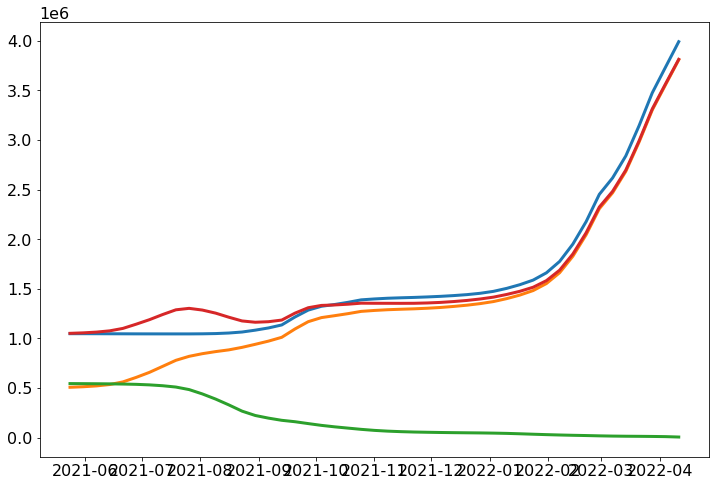

In [ ]:
fig,ax1 = plt.subplots()

curCase = df_main['antal_cases_Ingen vaccination'].values[::-1]
curDates = allDTs[::-1]

ax1.plot(allDTs,df_main['antal_personer_alle_Ingen vaccination'])
ax1.plot(allDTs,df_main['antal_personer_Ingen vaccination'])
# ax1.plot(allDTs,df_main['antal_cases_Ingen vaccination'])
# ax1.plot(allDTs,df_main['antal_cases_Ingen vaccination']+df_main['antal_personer_Ingen vaccination'])
ax1.plot(curDates,np.cumsum(curCase))
ax1.plot(curDates,np.cumsum(curCase)+df_main['antal_personer_Ingen vaccination'].values[::-1])

In [ ]:
curdf = df_main.iloc[::-1,:]
curDates = allDTs[::-1]

thisCase = curdf['antal_personer_alle_Ingen vaccination']-curdf['antal_personer_Ingen vaccination']
thisCase.diff().tail(20)

curdf.iloc[:,[1,6]]
thisCase

15    183073
15    177806
15    173036
15    164910
15    155973
15    149926
15    144860
15    132641
15    122465
15    113865
15    108349
15    105515
15    104758
15    103317
15    103071
15    104086
15    106534
14    109340
13    112199
15    114037
15    114996
15    115377
15    115763
15    115988
15    116256
15    114150
15    112744
15    114129
15    116775
15    120797
15    124627
15    132795
14    142740
13    154733
12    169941
11    181894
10    200481
9     226210
8     266348
7     327347
6     388186
5     439066
4     484878
3     511837
2     526159
1     535017
0     540460
dtype: int64

In [ ]:
curdf['antal_cases_Ingen vaccination'].tail(20)

15    14768
15    17988
15    18864
15    14216
15    21909
14    26702
13    43875
12    62936
11    58908
10    51724
9     43859
8     25509
7     13323
6      8628
5      5334
4      2933
3      1889
2      1180
1       868
0       637
Name: antal_cases_Ingen vaccination, dtype: int64

In [ ]:
# curdf.columns

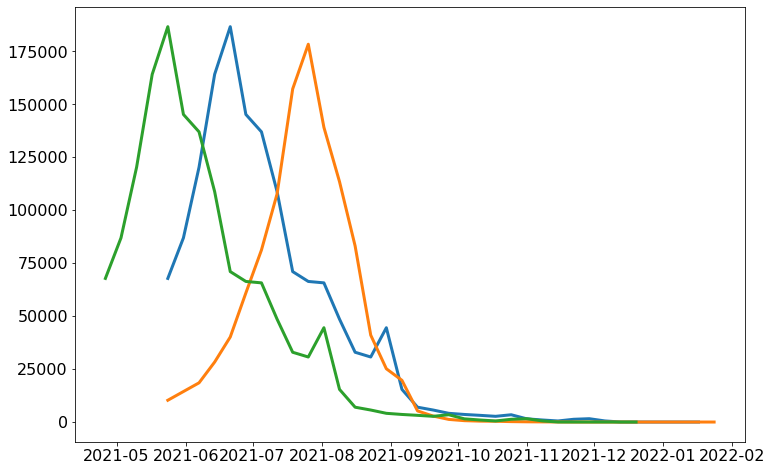

In [ ]:
curdf = df_main.iloc[::-1,:]
curDates = allDTs[::-1]



fig,ax1 = plt.subplots()

thisCase = curdf['antal_personer_alle_Fuld effekt efter revaccination']-curdf['antal_personer_Fuld effekt efter revaccination']
# ax1.plot(curDates,curdf['antal_personer_alle_Fuld effekt efter revaccination']-curdf['antal_personer_Fuld effekt efter revaccination'])
ax1.plot(curDates,thisCase.diff())
# ax1.plot(curDates,curdf['antal_personer_alle_Fuld effekt efter revaccination'])
ax1.plot(curDates,curdf['antal_cases_Fuld effekt efter revaccination'])

ax1.plot(curDates-np.timedelta64(4*7,'D'),thisCase.diff())

In [ ]:
# .loc[:,'antal_personer_alle_Fuld vaccineeffekt'].tail(20)
# df_main.reset_index(drop=True).tail(20)
# antalPrim = df_main


In [ ]:
df_main.loc[:,'antal_personer_alle_Fuld vaccineeffekt'].tail(20)

KeyError: 'antal_personer_alle_Fuld vaccineeffekt'

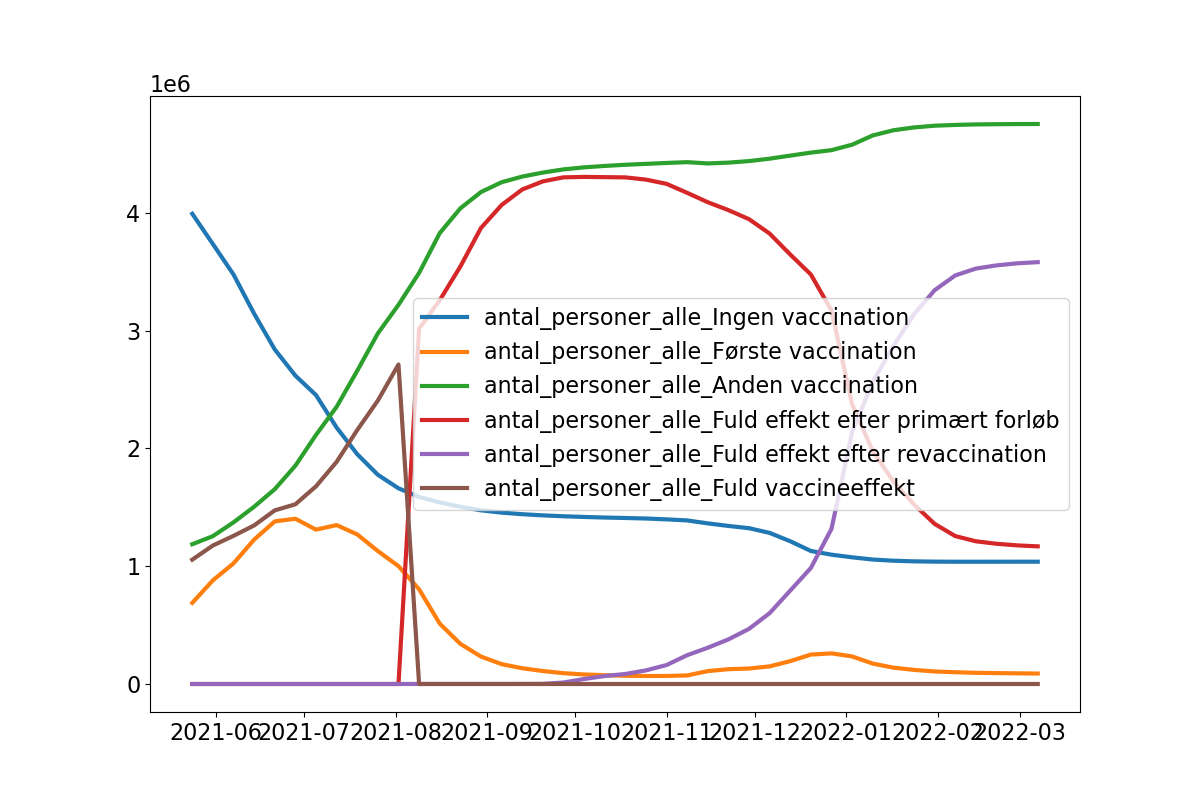

In [ ]:
fig,ax1 = plt.subplots()

curCol = df_main.columns[1]
ax1.plot(allDTs,df_main[curCol],label=curCol)
curCol = df_main.columns[2]
ax1.plot(allDTs,df_main[curCol],label=curCol)
curCol = df_main.columns[3]
ax1.plot(allDTs,df_main[curCol],label=curCol)
curCol = df_main.columns[4]
ax1.plot(allDTs,df_main[curCol],label=curCol) 
curCol = df_main.columns[5]
ax1.plot(allDTs,df_main[curCol],label=curCol) 
curCol = df_main.columns[-4]
ax1.plot(allDTs,df_main[curCol],label=curCol) 

ax1.legend()



unva = df_main.iloc[:,1]
once = df_main.iloc[:,2]
both = df_main.iloc[:,3]
full_pri = df_main.iloc[:,4]
reva = df_main.iloc[:,5]
full_old = df_main.iloc[:,-4]

# Weird error in 2022-03-08 file...

In [ ]:
# allRows[0]

dirPath = path_data + 'SSI_data_2022-03-08'+ '/'
filePath = dirPath+'gennembrudsinfektioner_table1.csv'
if os.path.exists(filePath):
    df1 = pd.read_csv(filePath,delimiter=';')
display(df1)
dirPath = path_data + 'SSI_data_2022-03-01'+ '/'
filePath = dirPath+'gennembrudsinfektioner_table1.csv'
if os.path.exists(filePath):
    df1 = pd.read_csv(filePath,delimiter=';')
display(df1)

,Ugenummer,antal_personer_alle_Ingen vaccination,antal_personer_alle_Første vaccination,antal_personer_alle_Anden vaccination,antal_personer_alle_Fuld effekt efter primært forløb,antal_personer_alle_Fuld effekt efter revaccination,antal_personer_Ingen vaccination,antal_personer_Første vaccination,antal_personer_Anden vaccination,antal_personer_Fuld effekt efter primært forløb,...,antal_repositive_Ingen vaccination,antal_repositive_Første vaccination,antal_repositive_Anden vaccination,antal_repositive_Fuld effekt efter primært forløb,antal_repositive_Fuld effekt efter revaccination,antal_indlagte_Ingen vaccination,antal_indlagte_Første vaccination,antal_indlagte_Anden vaccination,antal_indlagte_Fuld effekt efter primært forløb,antal_indlagte_Fuld effekt efter revaccination
0,Uge 09-2022,1036629,85166,4758872,1182200,3571335,648321,36475,3560570,644238,...,1418,100,4327,1477,2840,311,21,1725,233,1491
1,Uge 08-2022,1036705,87308,4757523,1195726,3553756,709262,44379,3777750,740574,...,2010,178,6115,2057,4042,392,34,2020,326,1691
2,Uge 07-2022,1036531,89672,4755864,1216839,3526732,770118,54214,3964394,843025,...,3357,253,9222,3474,5716,550,38,2161,410,1749
3,Uge 06-2022,1036556,94613,4751315,1261120,3468491,810302,63526,4074690,933769,...,5496,380,12100,5132,6895,629,45,2010,508,1495
4,Uge 05-2022,1037403,101124,4744883,1364712,3343127,836890,72092,4170339,1075442,...,5617,391,9925,4615,5184,600,43,1644,467,1164
5,Uge 04-2022,1039657,114557,4730096,1529422,3138937,857730,85523,4247024,1266684,...,7003,479,10112,5637,4311,527,35,1310,496,796
6,Uge 03-2022,1045215,133480,4706197,1725821,2868789,875245,104236,4286763,1480910,...,7903,502,9694,6195,3263,518,44,1022,462,544
7,Uge 02-2022,1055253,167922,4662303,1981759,2564442,900500,139402,4296666,1755609,...,5265,362,6196,4389,1649,437,49,815,393,415
8,Uge 01-2022,1073998,228796,4583610,2378764,2140610,931237,198609,4252839,2151371,...,3753,362,5891,4802,1002,347,38,737,406,324
9,Uge 52-2021,1096233,254571,4537284,3174620,1317702,963427,224854,4229159,2925859,...,2452,235,4379,3675,646,357,43,745,464,274


,Ugenummer,antal_personer_alle_Ingen vaccination,antal_personer_alle_Første vaccination,antal_personer_alle_Anden vaccination,antal_personer_alle_Fuld effekt efter primært forløb,antal_personer_alle_Fuld effekt efter revaccination,antal_personer_Ingen vaccination,antal_personer_Første vaccination,antal_personer_Anden vaccination,antal_personer_Fuld effekt efter primært forløb,...,antal_repositive_Ingen vaccination,antal_repositive_Første vaccination,antal_repositive_Anden vaccination,antal_repositive_Fuld effekt efter primært forløb,antal_repositive_Fuld effekt efter revaccination,antal_indlagte_Ingen vaccination,antal_indlagte_Første vaccination,antal_indlagte_Anden vaccination,antal_indlagte_Fuld effekt efter primært forløb,antal_indlagte_Fuld effekt efter revaccination
0,Uge 08-2022,1035495,87033,4757629,1155303,3594463,708017,44201,3777776,709633,...,2009,176,6115,1988,4111,386,34,2005,320,1682
1,Uge 07-2022,1035666,89321,4756030,1176656,3567341,769222,53989,3964448,810393,...,3357,253,9222,3374,5816,552,37,2156,405,1749
2,Uge 06-2022,1035682,94137,4751591,1221542,3508831,809403,63229,4074804,900305,...,5495,380,12101,5024,7005,628,45,2011,502,1502
3,Uge 05-2022,1036518,100477,4745306,1326582,3382774,835984,71663,4170565,1041932,...,5618,389,9926,4532,5269,601,43,1639,460,1166
4,Uge 04-2022,1038767,113505,4730914,1493446,3177572,856820,84780,4247555,1234165,...,7004,477,10113,5577,4374,527,35,1307,493,797
5,Uge 03-2022,1044321,131511,4707918,1692560,2906120,874331,102721,4288048,1450093,...,7905,500,9694,6144,3319,518,44,1021,461,545
6,Uge 02-2022,1054355,164846,4665130,1950614,2600769,899585,136903,4298932,1726225,...,5265,360,6198,4351,1693,437,49,815,392,416
7,Uge 01-2022,1073098,224208,4587940,2351263,2175147,930322,194789,4256416,2125121,...,3757,357,5893,4765,1047,347,38,736,403,327
8,Uge 52-2021,1095329,248796,4542788,3154388,1348645,962509,219934,4233823,2906044,...,2452,234,4380,3658,669,357,44,745,463,276
9,Uge 51-2021,1126865,236568,4524190,3466609,1013777,1002212,209473,4233781,3222611,...,1027,122,2398,2157,206,316,28,490,357,124


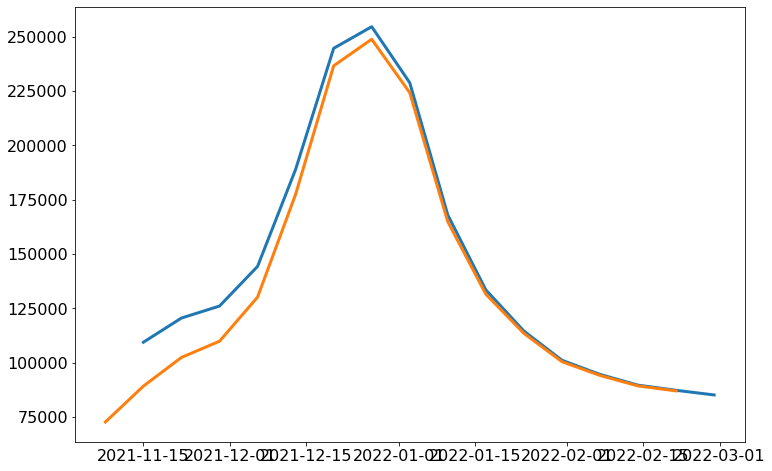

In [ ]:
fig,ax1 = plt.subplots() 



dirPath = path_data + 'SSI_data_2022-03-08'+ '/'
filePath = dirPath+'gennembrudsinfektioner_table1.csv'
if os.path.exists(filePath):
    df1 = pd.read_csv(filePath,delimiter=';')

# display(df1)

weekDTs = [np.datetime64(datetime.datetime.strptime(d[-4:] + '-W'+d[4:6]+'-1', "%Y-W%W-%w")) for d in df1.Ugenummer]

ax1.plot(weekDTs,df1.iloc[:,2])


dirPath = path_data + 'SSI_data_2022-03-01'+ '/'
filePath = dirPath+'gennembrudsinfektioner_table1.csv'
if os.path.exists(filePath):
    df1 = pd.read_csv(filePath,delimiter=';')
# display(df1)


weekDTs = [np.datetime64(datetime.datetime.strptime(d[-4:] + '-W'+d[4:6]+'-1', "%Y-W%W-%w")) for d in df1.Ugenummer]

ax1.plot(weekDTs,df1.iloc[:,2])

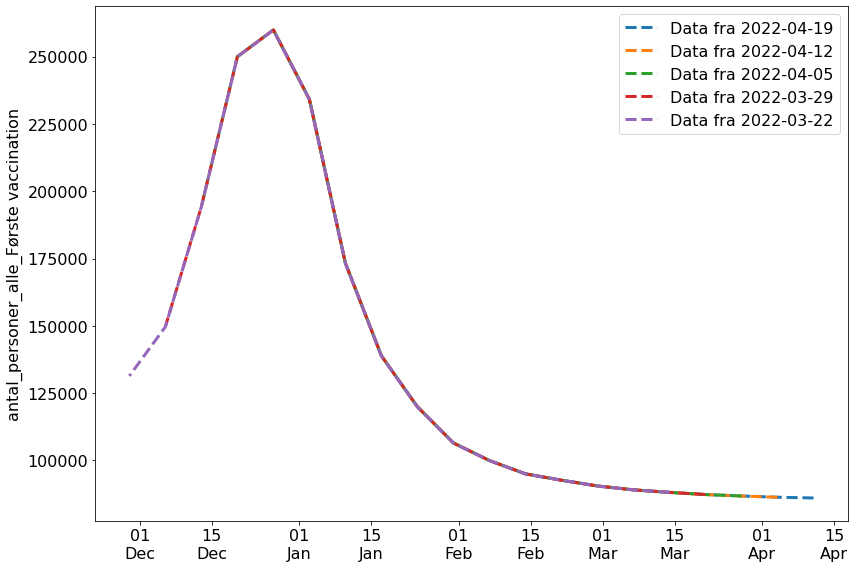

In [ ]:
fig,ax1 = plt.subplots()
curCol = 2
maxWeeksBack = 5
for k in range(0,maxWeeksBack):
    curTue = mostRecentTuesday - np.timedelta64(7*k,'D')
    curTuePath = 'SSI_data_'+str(curTue)

    dirPath = path_data + curTuePath + '/'
    filePath = dirPath+'gennembrudsinfektioner_table1.csv'
    if os.path.exists(filePath):
        df1 = pd.read_csv(filePath,delimiter=';')
    else:
        continue
    
    weekDTs = [np.datetime64(datetime.datetime.strptime(d[-4:] + '-W'+d[4:6]+'-1', "%Y-W%W-%w")) for d in df1.Ugenummer]

    ax1.plot(weekDTs,df1.iloc[:,curCol],'--',label=f'Data fra {curTue}')
ax1.legend()

ax1.set_ylabel(df1.columns[curCol])
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b'))
fig.tight_layout()
